In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#         y -= l.sigmoid(0.0) # zero-centered/ mean
#         y *= 2.0 # uni-var/ std
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#             y -= l.sigmoid(0.0) # zero-centered/ mean
#             y *= 2.0 # uni-var/ std
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
        y_prev = self.y_prev.copy() # for temporal differencing
        self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
        y =  y @ self.W_fixed[2].T # done
        y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
            dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
            y =  y @ self.W_fixed[1][layer].T # done
            y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
        dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [4]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.2982, acc-0.1200, valid loss-2.2982, acc-0.1064, test loss-2.3020, acc-0.1102
Iter-20, train loss-2.2774, acc-0.1400, valid loss-2.2981, acc-0.1066, test loss-2.3019, acc-0.1100
Iter-30, train loss-2.2796, acc-0.1000, valid loss-2.2981, acc-0.1062, test loss-2.3018, acc-0.1100
Iter-40, train loss-2.3075, acc-0.0800, valid loss-2.2980, acc-0.1060, test loss-2.3017, acc-0.1103
Iter-50, train loss-2.2879, acc-0.1400, valid loss-2.2979, acc-0.1064, test loss-2.3016, acc-0.1101
Iter-60, train loss-2.3075, acc-0.1800, valid loss-2.2978, acc-0.1064, test loss-2.3015, acc-0.1103
Iter-70, train loss-2.2745, acc-0.1800, valid loss-2.2977, acc-0.1064, test loss-2.3014, acc-0.1108
Iter-80, train loss-2.3075, acc-0.1000, valid loss-2.2976, acc-0.1062, test loss-2.3013, acc-0.1109
Iter-90, train loss-2.3128, acc-0.1200, valid loss-2.2975, acc-0.1062, test loss-2.3012, acc-0.1108
Iter-100, train loss-2.3038, acc-0.1200, valid loss-2.2974, acc-0.1062, test loss-2.3011, acc-0.1111

Iter-830, train loss-2.2956, acc-0.1000, valid loss-2.2910, acc-0.1164, test loss-2.2941, acc-0.1204
Iter-840, train loss-2.2942, acc-0.1000, valid loss-2.2910, acc-0.1172, test loss-2.2940, acc-0.1207
Iter-850, train loss-2.2835, acc-0.1400, valid loss-2.2909, acc-0.1170, test loss-2.2939, acc-0.1206
Iter-860, train loss-2.2704, acc-0.1600, valid loss-2.2908, acc-0.1168, test loss-2.2938, acc-0.1206
Iter-870, train loss-2.2868, acc-0.2000, valid loss-2.2907, acc-0.1172, test loss-2.2937, acc-0.1208
Iter-880, train loss-2.3125, acc-0.1000, valid loss-2.2906, acc-0.1174, test loss-2.2937, acc-0.1211
Iter-890, train loss-2.2918, acc-0.1200, valid loss-2.2905, acc-0.1180, test loss-2.2936, acc-0.1211
Iter-900, train loss-2.3059, acc-0.1200, valid loss-2.2904, acc-0.1176, test loss-2.2935, acc-0.1212
Iter-910, train loss-2.2753, acc-0.2000, valid loss-2.2904, acc-0.1176, test loss-2.2934, acc-0.1212
Iter-920, train loss-2.3018, acc-0.0800, valid loss-2.2903, acc-0.1176, test loss-2.2933, a

Iter-1640, train loss-2.3068, acc-0.1400, valid loss-2.2841, acc-0.1280, test loss-2.2865, acc-0.1303
Iter-1650, train loss-2.2668, acc-0.2200, valid loss-2.2840, acc-0.1278, test loss-2.2864, acc-0.1307
Iter-1660, train loss-2.2876, acc-0.1400, valid loss-2.2839, acc-0.1280, test loss-2.2863, acc-0.1310
Iter-1670, train loss-2.3023, acc-0.1800, valid loss-2.2838, acc-0.1282, test loss-2.2862, acc-0.1310
Iter-1680, train loss-2.2896, acc-0.1400, valid loss-2.2837, acc-0.1280, test loss-2.2861, acc-0.1311
Iter-1690, train loss-2.2816, acc-0.1200, valid loss-2.2837, acc-0.1288, test loss-2.2860, acc-0.1310
Iter-1700, train loss-2.2822, acc-0.1800, valid loss-2.2836, acc-0.1288, test loss-2.2859, acc-0.1310
Iter-1710, train loss-2.2700, acc-0.1400, valid loss-2.2835, acc-0.1288, test loss-2.2858, acc-0.1310
Iter-1720, train loss-2.2979, acc-0.1000, valid loss-2.2834, acc-0.1288, test loss-2.2857, acc-0.1311
Iter-1730, train loss-2.2682, acc-0.1800, valid loss-2.2833, acc-0.1292, test loss

Iter-2450, train loss-2.2910, acc-0.1200, valid loss-2.2772, acc-0.1410, test loss-2.2789, acc-0.1420
Iter-2460, train loss-2.2829, acc-0.0800, valid loss-2.2771, acc-0.1412, test loss-2.2788, acc-0.1421
Iter-2470, train loss-2.2730, acc-0.1600, valid loss-2.2770, acc-0.1412, test loss-2.2787, acc-0.1418
Iter-2480, train loss-2.2745, acc-0.1000, valid loss-2.2769, acc-0.1414, test loss-2.2786, acc-0.1426
Iter-2490, train loss-2.2887, acc-0.0800, valid loss-2.2768, acc-0.1416, test loss-2.2785, acc-0.1427
Iter-2500, train loss-2.2551, acc-0.1000, valid loss-2.2768, acc-0.1416, test loss-2.2784, acc-0.1428
Iter-2510, train loss-2.3081, acc-0.0800, valid loss-2.2767, acc-0.1418, test loss-2.2784, acc-0.1428
Iter-2520, train loss-2.2792, acc-0.0400, valid loss-2.2766, acc-0.1418, test loss-2.2783, acc-0.1430
Iter-2530, train loss-2.2728, acc-0.1200, valid loss-2.2765, acc-0.1420, test loss-2.2782, acc-0.1431
Iter-2540, train loss-2.2653, acc-0.2400, valid loss-2.2764, acc-0.1420, test loss

Iter-3260, train loss-2.2734, acc-0.1800, valid loss-2.2704, acc-0.1526, test loss-2.2715, acc-0.1553
Iter-3270, train loss-2.2961, acc-0.1600, valid loss-2.2703, acc-0.1534, test loss-2.2714, acc-0.1554
Iter-3280, train loss-2.2751, acc-0.1400, valid loss-2.2703, acc-0.1530, test loss-2.2713, acc-0.1556
Iter-3290, train loss-2.2842, acc-0.1800, valid loss-2.2702, acc-0.1536, test loss-2.2712, acc-0.1561
Iter-3300, train loss-2.2849, acc-0.2000, valid loss-2.2701, acc-0.1538, test loss-2.2712, acc-0.1564
Iter-3310, train loss-2.2844, acc-0.2000, valid loss-2.2700, acc-0.1542, test loss-2.2711, acc-0.1565
Iter-3320, train loss-2.2678, acc-0.1600, valid loss-2.2699, acc-0.1550, test loss-2.2710, acc-0.1568
Iter-3330, train loss-2.2691, acc-0.2200, valid loss-2.2698, acc-0.1550, test loss-2.2709, acc-0.1569
Iter-3340, train loss-2.2508, acc-0.1400, valid loss-2.2698, acc-0.1554, test loss-2.2708, acc-0.1570
Iter-3350, train loss-2.2827, acc-0.1800, valid loss-2.2697, acc-0.1554, test loss

Iter-4070, train loss-2.2571, acc-0.1600, valid loss-2.2638, acc-0.1666, test loss-2.2642, acc-0.1716
Iter-4080, train loss-2.2261, acc-0.2400, valid loss-2.2637, acc-0.1670, test loss-2.2641, acc-0.1720
Iter-4090, train loss-2.2761, acc-0.1600, valid loss-2.2636, acc-0.1670, test loss-2.2640, acc-0.1724
Iter-4100, train loss-2.2813, acc-0.1200, valid loss-2.2635, acc-0.1672, test loss-2.2639, acc-0.1724
Iter-4110, train loss-2.2771, acc-0.1400, valid loss-2.2634, acc-0.1672, test loss-2.2638, acc-0.1725
Iter-4120, train loss-2.2687, acc-0.1400, valid loss-2.2634, acc-0.1672, test loss-2.2637, acc-0.1726
Iter-4130, train loss-2.2737, acc-0.2400, valid loss-2.2633, acc-0.1674, test loss-2.2637, acc-0.1729
Iter-4140, train loss-2.2656, acc-0.0800, valid loss-2.2632, acc-0.1684, test loss-2.2636, acc-0.1733
Iter-4150, train loss-2.2729, acc-0.1600, valid loss-2.2631, acc-0.1686, test loss-2.2635, acc-0.1735
Iter-4160, train loss-2.2547, acc-0.2000, valid loss-2.2630, acc-0.1686, test loss

Iter-4880, train loss-2.2546, acc-0.1400, valid loss-2.2572, acc-0.1798, test loss-2.2570, acc-0.1840
Iter-4890, train loss-2.2743, acc-0.2000, valid loss-2.2571, acc-0.1796, test loss-2.2569, acc-0.1841
Iter-4900, train loss-2.2827, acc-0.1400, valid loss-2.2570, acc-0.1798, test loss-2.2568, acc-0.1842
Iter-4910, train loss-2.2397, acc-0.2600, valid loss-2.2569, acc-0.1804, test loss-2.2567, acc-0.1845
Iter-4920, train loss-2.2469, acc-0.1400, valid loss-2.2569, acc-0.1806, test loss-2.2566, acc-0.1848
Iter-4930, train loss-2.2427, acc-0.2400, valid loss-2.2568, acc-0.1806, test loss-2.2565, acc-0.1847
Iter-4940, train loss-2.2388, acc-0.2800, valid loss-2.2567, acc-0.1816, test loss-2.2564, acc-0.1846
Iter-4950, train loss-2.2661, acc-0.1200, valid loss-2.2566, acc-0.1824, test loss-2.2564, acc-0.1850
Iter-4960, train loss-2.3016, acc-0.1200, valid loss-2.2565, acc-0.1826, test loss-2.2563, acc-0.1854
Iter-4970, train loss-2.2588, acc-0.2200, valid loss-2.2564, acc-0.1824, test loss

Iter-5690, train loss-2.2476, acc-0.1600, valid loss-2.2507, acc-0.1950, test loss-2.2499, acc-0.1981
Iter-5700, train loss-2.2435, acc-0.1600, valid loss-2.2507, acc-0.1956, test loss-2.2498, acc-0.1980
Iter-5710, train loss-2.2610, acc-0.2000, valid loss-2.2506, acc-0.1962, test loss-2.2497, acc-0.1979
Iter-5720, train loss-2.2541, acc-0.2200, valid loss-2.2505, acc-0.1964, test loss-2.2496, acc-0.1978
Iter-5730, train loss-2.2510, acc-0.2200, valid loss-2.2504, acc-0.1970, test loss-2.2495, acc-0.1978
Iter-5740, train loss-2.2580, acc-0.1400, valid loss-2.2504, acc-0.1972, test loss-2.2494, acc-0.1985
Iter-5750, train loss-2.2526, acc-0.1800, valid loss-2.2503, acc-0.1974, test loss-2.2493, acc-0.1987
Iter-5760, train loss-2.2342, acc-0.2400, valid loss-2.2502, acc-0.1968, test loss-2.2493, acc-0.1987
Iter-5770, train loss-2.2818, acc-0.1600, valid loss-2.2501, acc-0.1966, test loss-2.2492, acc-0.1987
Iter-5780, train loss-2.2531, acc-0.1400, valid loss-2.2500, acc-0.1976, test loss

Iter-6500, train loss-2.2246, acc-0.2400, valid loss-2.2444, acc-0.2124, test loss-2.2429, acc-0.2115
Iter-6510, train loss-2.2309, acc-0.2400, valid loss-2.2443, acc-0.2130, test loss-2.2428, acc-0.2117
Iter-6520, train loss-2.2474, acc-0.1800, valid loss-2.2443, acc-0.2132, test loss-2.2427, acc-0.2116
Iter-6530, train loss-2.2269, acc-0.2000, valid loss-2.2442, acc-0.2130, test loss-2.2426, acc-0.2118
Iter-6540, train loss-2.2231, acc-0.2400, valid loss-2.2441, acc-0.2132, test loss-2.2426, acc-0.2118
Iter-6550, train loss-2.2420, acc-0.3000, valid loss-2.2440, acc-0.2132, test loss-2.2425, acc-0.2119
Iter-6560, train loss-2.2325, acc-0.2400, valid loss-2.2439, acc-0.2136, test loss-2.2424, acc-0.2121
Iter-6570, train loss-2.2349, acc-0.2000, valid loss-2.2439, acc-0.2136, test loss-2.2423, acc-0.2124
Iter-6580, train loss-2.2462, acc-0.1800, valid loss-2.2438, acc-0.2138, test loss-2.2422, acc-0.2126
Iter-6590, train loss-2.2256, acc-0.2200, valid loss-2.2437, acc-0.2140, test loss

Iter-7310, train loss-2.2094, acc-0.3200, valid loss-2.2381, acc-0.2266, test loss-2.2360, acc-0.2265
Iter-7320, train loss-2.2409, acc-0.2200, valid loss-2.2381, acc-0.2266, test loss-2.2359, acc-0.2268
Iter-7330, train loss-2.2358, acc-0.2400, valid loss-2.2380, acc-0.2270, test loss-2.2358, acc-0.2269
Iter-7340, train loss-2.2326, acc-0.2800, valid loss-2.2379, acc-0.2272, test loss-2.2358, acc-0.2268
Iter-7350, train loss-2.2333, acc-0.2400, valid loss-2.2378, acc-0.2276, test loss-2.2357, acc-0.2269
Iter-7360, train loss-2.2298, acc-0.3000, valid loss-2.2378, acc-0.2280, test loss-2.2356, acc-0.2266
Iter-7370, train loss-2.2307, acc-0.2000, valid loss-2.2377, acc-0.2282, test loss-2.2355, acc-0.2270
Iter-7380, train loss-2.2603, acc-0.1800, valid loss-2.2376, acc-0.2280, test loss-2.2354, acc-0.2276
Iter-7390, train loss-2.2447, acc-0.1600, valid loss-2.2375, acc-0.2282, test loss-2.2353, acc-0.2279
Iter-7400, train loss-2.2478, acc-0.1600, valid loss-2.2375, acc-0.2276, test loss

Iter-8120, train loss-2.2330, acc-0.2200, valid loss-2.2320, acc-0.2404, test loss-2.2293, acc-0.2425
Iter-8130, train loss-2.2258, acc-0.2000, valid loss-2.2319, acc-0.2406, test loss-2.2292, acc-0.2430
Iter-8140, train loss-2.2548, acc-0.1200, valid loss-2.2318, acc-0.2408, test loss-2.2291, acc-0.2431
Iter-8150, train loss-2.2424, acc-0.3400, valid loss-2.2318, acc-0.2412, test loss-2.2290, acc-0.2434
Iter-8160, train loss-2.2141, acc-0.3000, valid loss-2.2317, acc-0.2416, test loss-2.2290, acc-0.2435
Iter-8170, train loss-2.2241, acc-0.2800, valid loss-2.2316, acc-0.2414, test loss-2.2289, acc-0.2433
Iter-8180, train loss-2.2466, acc-0.2800, valid loss-2.2316, acc-0.2418, test loss-2.2288, acc-0.2439
Iter-8190, train loss-2.2304, acc-0.2000, valid loss-2.2315, acc-0.2420, test loss-2.2287, acc-0.2442
Iter-8200, train loss-2.2589, acc-0.1800, valid loss-2.2314, acc-0.2422, test loss-2.2286, acc-0.2444
Iter-8210, train loss-2.2402, acc-0.2600, valid loss-2.2313, acc-0.2430, test loss

Iter-8930, train loss-2.2502, acc-0.1800, valid loss-2.2259, acc-0.2566, test loss-2.2227, acc-0.2570
Iter-8940, train loss-2.2200, acc-0.2200, valid loss-2.2259, acc-0.2560, test loss-2.2226, acc-0.2569
Iter-8950, train loss-2.2122, acc-0.2800, valid loss-2.2258, acc-0.2564, test loss-2.2225, acc-0.2573
Iter-8960, train loss-2.2209, acc-0.3200, valid loss-2.2257, acc-0.2564, test loss-2.2224, acc-0.2575
Iter-8970, train loss-2.2392, acc-0.3200, valid loss-2.2256, acc-0.2560, test loss-2.2223, acc-0.2572
Iter-8980, train loss-2.2393, acc-0.1800, valid loss-2.2255, acc-0.2566, test loss-2.2222, acc-0.2576
Iter-8990, train loss-2.1918, acc-0.3600, valid loss-2.2255, acc-0.2566, test loss-2.2222, acc-0.2580
Iter-9000, train loss-2.2623, acc-0.2000, valid loss-2.2254, acc-0.2562, test loss-2.2221, acc-0.2581
Iter-9010, train loss-2.2345, acc-0.2200, valid loss-2.2253, acc-0.2564, test loss-2.2220, acc-0.2583
Iter-9020, train loss-2.2236, acc-0.2000, valid loss-2.2252, acc-0.2564, test loss

Iter-9740, train loss-2.1969, acc-0.2400, valid loss-2.2200, acc-0.2684, test loss-2.2161, acc-0.2721
Iter-9750, train loss-2.2167, acc-0.3400, valid loss-2.2199, acc-0.2688, test loss-2.2160, acc-0.2720
Iter-9760, train loss-2.2126, acc-0.2400, valid loss-2.2199, acc-0.2690, test loss-2.2159, acc-0.2724
Iter-9770, train loss-2.2531, acc-0.1400, valid loss-2.2198, acc-0.2690, test loss-2.2159, acc-0.2728
Iter-9780, train loss-2.2152, acc-0.3000, valid loss-2.2197, acc-0.2696, test loss-2.2158, acc-0.2729
Iter-9790, train loss-2.2447, acc-0.2200, valid loss-2.2196, acc-0.2694, test loss-2.2157, acc-0.2733
Iter-9800, train loss-2.2461, acc-0.2200, valid loss-2.2196, acc-0.2700, test loss-2.2156, acc-0.2732
Iter-9810, train loss-2.2422, acc-0.1400, valid loss-2.2195, acc-0.2694, test loss-2.2156, acc-0.2734
Iter-9820, train loss-2.2232, acc-0.2400, valid loss-2.2194, acc-0.2700, test loss-2.2155, acc-0.2741
Iter-9830, train loss-2.2194, acc-0.2600, valid loss-2.2194, acc-0.2706, test loss

Iter-10540, train loss-2.2264, acc-0.3000, valid loss-2.2142, acc-0.2800, test loss-2.2098, acc-0.2861
Iter-10550, train loss-2.2115, acc-0.2200, valid loss-2.2142, acc-0.2798, test loss-2.2097, acc-0.2862
Iter-10560, train loss-2.1784, acc-0.3800, valid loss-2.2141, acc-0.2806, test loss-2.2096, acc-0.2866
Iter-10570, train loss-2.2042, acc-0.3000, valid loss-2.2140, acc-0.2804, test loss-2.2096, acc-0.2866
Iter-10580, train loss-2.2099, acc-0.3200, valid loss-2.2140, acc-0.2808, test loss-2.2095, acc-0.2867
Iter-10590, train loss-2.2053, acc-0.3600, valid loss-2.2139, acc-0.2810, test loss-2.2094, acc-0.2875
Iter-10600, train loss-2.2167, acc-0.2600, valid loss-2.2138, acc-0.2810, test loss-2.2093, acc-0.2874
Iter-10610, train loss-2.2220, acc-0.2000, valid loss-2.2137, acc-0.2812, test loss-2.2092, acc-0.2875
Iter-10620, train loss-2.2222, acc-0.3400, valid loss-2.2137, acc-0.2814, test loss-2.2092, acc-0.2883
Iter-10630, train loss-2.1943, acc-0.2400, valid loss-2.2136, acc-0.2814,

Iter-11340, train loss-2.2050, acc-0.2200, valid loss-2.2085, acc-0.2922, test loss-2.2034, acc-0.2973
Iter-11350, train loss-2.2065, acc-0.3400, valid loss-2.2084, acc-0.2926, test loss-2.2034, acc-0.2976
Iter-11360, train loss-2.2166, acc-0.3200, valid loss-2.2083, acc-0.2928, test loss-2.2033, acc-0.2978
Iter-11370, train loss-2.2000, acc-0.2800, valid loss-2.2083, acc-0.2934, test loss-2.2032, acc-0.2979
Iter-11380, train loss-2.2171, acc-0.2800, valid loss-2.2082, acc-0.2932, test loss-2.2031, acc-0.2985
Iter-11390, train loss-2.2046, acc-0.3000, valid loss-2.2081, acc-0.2932, test loss-2.2031, acc-0.2986
Iter-11400, train loss-2.2414, acc-0.2600, valid loss-2.2081, acc-0.2936, test loss-2.2030, acc-0.2989
Iter-11410, train loss-2.2051, acc-0.2200, valid loss-2.2080, acc-0.2940, test loss-2.2029, acc-0.2994
Iter-11420, train loss-2.2299, acc-0.2800, valid loss-2.2079, acc-0.2936, test loss-2.2028, acc-0.2993
Iter-11430, train loss-2.2201, acc-0.2600, valid loss-2.2078, acc-0.2940,

Iter-12140, train loss-2.2138, acc-0.3200, valid loss-2.2029, acc-0.3046, test loss-2.1973, acc-0.3107
Iter-12150, train loss-2.1892, acc-0.3800, valid loss-2.2028, acc-0.3052, test loss-2.1972, acc-0.3105
Iter-12160, train loss-2.2247, acc-0.3200, valid loss-2.2027, acc-0.3046, test loss-2.1971, acc-0.3112
Iter-12170, train loss-2.1658, acc-0.3000, valid loss-2.2027, acc-0.3044, test loss-2.1971, acc-0.3106
Iter-12180, train loss-2.2114, acc-0.2400, valid loss-2.2026, acc-0.3046, test loss-2.1970, acc-0.3113
Iter-12190, train loss-2.2094, acc-0.2400, valid loss-2.2025, acc-0.3048, test loss-2.1969, acc-0.3113
Iter-12200, train loss-2.2147, acc-0.3200, valid loss-2.2025, acc-0.3048, test loss-2.1968, acc-0.3116
Iter-12210, train loss-2.1892, acc-0.3000, valid loss-2.2024, acc-0.3054, test loss-2.1967, acc-0.3114
Iter-12220, train loss-2.1904, acc-0.3400, valid loss-2.2023, acc-0.3058, test loss-2.1967, acc-0.3120
Iter-12230, train loss-2.1946, acc-0.3800, valid loss-2.2022, acc-0.3060,

Iter-12940, train loss-2.2022, acc-0.3200, valid loss-2.1973, acc-0.3160, test loss-2.1911, acc-0.3188
Iter-12950, train loss-2.2027, acc-0.3600, valid loss-2.1972, acc-0.3168, test loss-2.1911, acc-0.3184
Iter-12960, train loss-2.2082, acc-0.2800, valid loss-2.1971, acc-0.3170, test loss-2.1910, acc-0.3185
Iter-12970, train loss-2.2326, acc-0.2800, valid loss-2.1971, acc-0.3168, test loss-2.1909, acc-0.3188
Iter-12980, train loss-2.1850, acc-0.3400, valid loss-2.1970, acc-0.3170, test loss-2.1908, acc-0.3191
Iter-12990, train loss-2.1642, acc-0.2800, valid loss-2.1969, acc-0.3182, test loss-2.1908, acc-0.3189
Iter-13000, train loss-2.2154, acc-0.2800, valid loss-2.1969, acc-0.3180, test loss-2.1907, acc-0.3191
Iter-13010, train loss-2.2360, acc-0.2200, valid loss-2.1968, acc-0.3180, test loss-2.1906, acc-0.3193
Iter-13020, train loss-2.2080, acc-0.3600, valid loss-2.1967, acc-0.3188, test loss-2.1905, acc-0.3194
Iter-13030, train loss-2.1833, acc-0.4000, valid loss-2.1966, acc-0.3182,

Iter-13740, train loss-2.1751, acc-0.3800, valid loss-2.1918, acc-0.3282, test loss-2.1851, acc-0.3298
Iter-13750, train loss-2.1783, acc-0.3600, valid loss-2.1917, acc-0.3282, test loss-2.1850, acc-0.3300
Iter-13760, train loss-2.1641, acc-0.2800, valid loss-2.1916, acc-0.3280, test loss-2.1849, acc-0.3305
Iter-13770, train loss-2.1882, acc-0.2800, valid loss-2.1915, acc-0.3282, test loss-2.1848, acc-0.3304
Iter-13780, train loss-2.1990, acc-0.3600, valid loss-2.1915, acc-0.3280, test loss-2.1848, acc-0.3305
Iter-13790, train loss-2.1887, acc-0.3000, valid loss-2.1914, acc-0.3278, test loss-2.1847, acc-0.3305
Iter-13800, train loss-2.1987, acc-0.3200, valid loss-2.1913, acc-0.3288, test loss-2.1846, acc-0.3308
Iter-13810, train loss-2.1663, acc-0.3600, valid loss-2.1913, acc-0.3290, test loss-2.1845, acc-0.3309
Iter-13820, train loss-2.1709, acc-0.3200, valid loss-2.1912, acc-0.3286, test loss-2.1844, acc-0.3310
Iter-13830, train loss-2.1841, acc-0.3000, valid loss-2.1911, acc-0.3294,

Iter-14540, train loss-2.1633, acc-0.4400, valid loss-2.1863, acc-0.3386, test loss-2.1791, acc-0.3410
Iter-14550, train loss-2.2027, acc-0.3200, valid loss-2.1862, acc-0.3386, test loss-2.1790, acc-0.3408
Iter-14560, train loss-2.1713, acc-0.3400, valid loss-2.1862, acc-0.3384, test loss-2.1789, acc-0.3411
Iter-14570, train loss-2.1810, acc-0.4200, valid loss-2.1861, acc-0.3382, test loss-2.1788, acc-0.3414
Iter-14580, train loss-2.1746, acc-0.3800, valid loss-2.1860, acc-0.3388, test loss-2.1788, acc-0.3417
Iter-14590, train loss-2.1750, acc-0.3200, valid loss-2.1860, acc-0.3388, test loss-2.1787, acc-0.3420
Iter-14600, train loss-2.1952, acc-0.2400, valid loss-2.1859, acc-0.3386, test loss-2.1786, acc-0.3421
Iter-14610, train loss-2.1924, acc-0.2600, valid loss-2.1858, acc-0.3388, test loss-2.1786, acc-0.3418
Iter-14620, train loss-2.1993, acc-0.2600, valid loss-2.1858, acc-0.3390, test loss-2.1785, acc-0.3420
Iter-14630, train loss-2.2235, acc-0.3000, valid loss-2.1857, acc-0.3392,

Iter-15340, train loss-2.1977, acc-0.2200, valid loss-2.1809, acc-0.3464, test loss-2.1731, acc-0.3501
Iter-15350, train loss-2.1682, acc-0.3600, valid loss-2.1809, acc-0.3464, test loss-2.1731, acc-0.3506
Iter-15360, train loss-2.1599, acc-0.3600, valid loss-2.1808, acc-0.3464, test loss-2.1730, acc-0.3506
Iter-15370, train loss-2.1954, acc-0.3800, valid loss-2.1807, acc-0.3464, test loss-2.1729, acc-0.3505
Iter-15380, train loss-2.1582, acc-0.3400, valid loss-2.1807, acc-0.3466, test loss-2.1729, acc-0.3510
Iter-15390, train loss-2.1581, acc-0.4200, valid loss-2.1806, acc-0.3466, test loss-2.1728, acc-0.3512
Iter-15400, train loss-2.1636, acc-0.3000, valid loss-2.1805, acc-0.3466, test loss-2.1727, acc-0.3512
Iter-15410, train loss-2.1923, acc-0.3000, valid loss-2.1805, acc-0.3474, test loss-2.1726, acc-0.3509
Iter-15420, train loss-2.1608, acc-0.4200, valid loss-2.1804, acc-0.3480, test loss-2.1726, acc-0.3514
Iter-15430, train loss-2.1630, acc-0.3000, valid loss-2.1803, acc-0.3474,

Iter-16140, train loss-2.1834, acc-0.3200, valid loss-2.1756, acc-0.3528, test loss-2.1673, acc-0.3608
Iter-16150, train loss-2.1666, acc-0.4600, valid loss-2.1755, acc-0.3524, test loss-2.1672, acc-0.3609
Iter-16160, train loss-2.1900, acc-0.2600, valid loss-2.1755, acc-0.3528, test loss-2.1672, acc-0.3610
Iter-16170, train loss-2.1902, acc-0.3400, valid loss-2.1754, acc-0.3532, test loss-2.1671, acc-0.3608
Iter-16180, train loss-2.1635, acc-0.3200, valid loss-2.1753, acc-0.3530, test loss-2.1670, acc-0.3613
Iter-16190, train loss-2.1924, acc-0.2800, valid loss-2.1753, acc-0.3532, test loss-2.1669, acc-0.3612
Iter-16200, train loss-2.1525, acc-0.2800, valid loss-2.1752, acc-0.3532, test loss-2.1669, acc-0.3615
Iter-16210, train loss-2.1584, acc-0.4000, valid loss-2.1751, acc-0.3532, test loss-2.1668, acc-0.3615
Iter-16220, train loss-2.1543, acc-0.4000, valid loss-2.1751, acc-0.3536, test loss-2.1667, acc-0.3615
Iter-16230, train loss-2.1994, acc-0.2600, valid loss-2.1750, acc-0.3534,

Iter-16940, train loss-2.1585, acc-0.3800, valid loss-2.1704, acc-0.3580, test loss-2.1616, acc-0.3683
Iter-16950, train loss-2.1422, acc-0.3800, valid loss-2.1703, acc-0.3584, test loss-2.1615, acc-0.3682
Iter-16960, train loss-2.1163, acc-0.3600, valid loss-2.1702, acc-0.3584, test loss-2.1614, acc-0.3682
Iter-16970, train loss-2.1157, acc-0.5600, valid loss-2.1702, acc-0.3586, test loss-2.1614, acc-0.3685
Iter-16980, train loss-2.1926, acc-0.2800, valid loss-2.1701, acc-0.3584, test loss-2.1613, acc-0.3684
Iter-16990, train loss-2.1737, acc-0.3000, valid loss-2.1701, acc-0.3584, test loss-2.1612, acc-0.3682
Iter-17000, train loss-2.1594, acc-0.3600, valid loss-2.1700, acc-0.3584, test loss-2.1611, acc-0.3684
Iter-17010, train loss-2.1155, acc-0.4400, valid loss-2.1699, acc-0.3588, test loss-2.1611, acc-0.3686
Iter-17020, train loss-2.2170, acc-0.2600, valid loss-2.1699, acc-0.3588, test loss-2.1610, acc-0.3692
Iter-17030, train loss-2.1513, acc-0.4200, valid loss-2.1698, acc-0.3590,

Iter-17740, train loss-2.1781, acc-0.3200, valid loss-2.1653, acc-0.3674, test loss-2.1559, acc-0.3754
Iter-17750, train loss-2.1549, acc-0.4200, valid loss-2.1652, acc-0.3678, test loss-2.1558, acc-0.3756
Iter-17760, train loss-2.1774, acc-0.2800, valid loss-2.1651, acc-0.3674, test loss-2.1558, acc-0.3758
Iter-17770, train loss-2.1328, acc-0.4400, valid loss-2.1651, acc-0.3672, test loss-2.1557, acc-0.3757
Iter-17780, train loss-2.1516, acc-0.4600, valid loss-2.1650, acc-0.3672, test loss-2.1556, acc-0.3757
Iter-17790, train loss-2.1605, acc-0.2800, valid loss-2.1649, acc-0.3672, test loss-2.1556, acc-0.3758
Iter-17800, train loss-2.1729, acc-0.3200, valid loss-2.1649, acc-0.3672, test loss-2.1555, acc-0.3760
Iter-17810, train loss-2.1219, acc-0.3400, valid loss-2.1648, acc-0.3668, test loss-2.1554, acc-0.3760
Iter-17820, train loss-2.1196, acc-0.4400, valid loss-2.1647, acc-0.3664, test loss-2.1554, acc-0.3759
Iter-17830, train loss-2.1844, acc-0.3200, valid loss-2.1647, acc-0.3666,

Iter-18540, train loss-2.1549, acc-0.4000, valid loss-2.1601, acc-0.3738, test loss-2.1503, acc-0.3824
Iter-18550, train loss-2.1542, acc-0.4000, valid loss-2.1601, acc-0.3740, test loss-2.1502, acc-0.3822
Iter-18560, train loss-2.1431, acc-0.3600, valid loss-2.1600, acc-0.3742, test loss-2.1501, acc-0.3828
Iter-18570, train loss-2.1027, acc-0.4400, valid loss-2.1600, acc-0.3742, test loss-2.1501, acc-0.3826
Iter-18580, train loss-2.1578, acc-0.4200, valid loss-2.1599, acc-0.3742, test loss-2.1500, acc-0.3827
Iter-18590, train loss-2.1085, acc-0.4400, valid loss-2.1598, acc-0.3742, test loss-2.1499, acc-0.3826
Iter-18600, train loss-2.1516, acc-0.3600, valid loss-2.1598, acc-0.3746, test loss-2.1499, acc-0.3827
Iter-18610, train loss-2.1926, acc-0.3600, valid loss-2.1597, acc-0.3746, test loss-2.1498, acc-0.3827
Iter-18620, train loss-2.1657, acc-0.3200, valid loss-2.1597, acc-0.3746, test loss-2.1497, acc-0.3828
Iter-18630, train loss-2.1332, acc-0.4000, valid loss-2.1596, acc-0.3746,

Iter-19340, train loss-2.2073, acc-0.2400, valid loss-2.1552, acc-0.3796, test loss-2.1448, acc-0.3891
Iter-19350, train loss-2.1102, acc-0.4600, valid loss-2.1551, acc-0.3794, test loss-2.1447, acc-0.3894
Iter-19360, train loss-2.1572, acc-0.3800, valid loss-2.1551, acc-0.3798, test loss-2.1447, acc-0.3892
Iter-19370, train loss-2.1164, acc-0.5200, valid loss-2.1550, acc-0.3798, test loss-2.1446, acc-0.3894
Iter-19380, train loss-2.1337, acc-0.3200, valid loss-2.1549, acc-0.3798, test loss-2.1445, acc-0.3898
Iter-19390, train loss-2.1629, acc-0.4000, valid loss-2.1549, acc-0.3800, test loss-2.1445, acc-0.3903
Iter-19400, train loss-2.1508, acc-0.4600, valid loss-2.1548, acc-0.3800, test loss-2.1444, acc-0.3903
Iter-19410, train loss-2.1503, acc-0.3600, valid loss-2.1547, acc-0.3802, test loss-2.1443, acc-0.3903
Iter-19420, train loss-2.1178, acc-0.5000, valid loss-2.1547, acc-0.3802, test loss-2.1443, acc-0.3904
Iter-19430, train loss-2.1908, acc-0.3400, valid loss-2.1546, acc-0.3804,

Iter-20140, train loss-2.1399, acc-0.3200, valid loss-2.1502, acc-0.3876, test loss-2.1393, acc-0.3966
Iter-20150, train loss-2.1583, acc-0.2800, valid loss-2.1502, acc-0.3878, test loss-2.1393, acc-0.3966
Iter-20160, train loss-2.1589, acc-0.2800, valid loss-2.1501, acc-0.3876, test loss-2.1392, acc-0.3966
Iter-20170, train loss-2.1657, acc-0.3000, valid loss-2.1500, acc-0.3878, test loss-2.1391, acc-0.3966
Iter-20180, train loss-2.1316, acc-0.4200, valid loss-2.1500, acc-0.3880, test loss-2.1391, acc-0.3968
Iter-20190, train loss-2.1666, acc-0.4400, valid loss-2.1499, acc-0.3880, test loss-2.1390, acc-0.3974
Iter-20200, train loss-2.1391, acc-0.4200, valid loss-2.1498, acc-0.3874, test loss-2.1389, acc-0.3972
Iter-20210, train loss-2.1563, acc-0.3800, valid loss-2.1498, acc-0.3880, test loss-2.1389, acc-0.3972
Iter-20220, train loss-2.1626, acc-0.4400, valid loss-2.1497, acc-0.3880, test loss-2.1388, acc-0.3973
Iter-20230, train loss-2.1091, acc-0.4200, valid loss-2.1497, acc-0.3882,

Iter-20940, train loss-2.1608, acc-0.3400, valid loss-2.1453, acc-0.3924, test loss-2.1340, acc-0.4025
Iter-20950, train loss-2.1342, acc-0.4800, valid loss-2.1453, acc-0.3930, test loss-2.1339, acc-0.4026
Iter-20960, train loss-2.1575, acc-0.3800, valid loss-2.1452, acc-0.3930, test loss-2.1338, acc-0.4026
Iter-20970, train loss-2.1769, acc-0.2800, valid loss-2.1451, acc-0.3930, test loss-2.1338, acc-0.4026
Iter-20980, train loss-2.1562, acc-0.3200, valid loss-2.1451, acc-0.3928, test loss-2.1337, acc-0.4029
Iter-20990, train loss-2.1393, acc-0.4400, valid loss-2.1450, acc-0.3928, test loss-2.1336, acc-0.4030
Iter-21000, train loss-2.1523, acc-0.4800, valid loss-2.1450, acc-0.3928, test loss-2.1336, acc-0.4030
Iter-21010, train loss-2.1459, acc-0.4800, valid loss-2.1449, acc-0.3938, test loss-2.1335, acc-0.4030
Iter-21020, train loss-2.1560, acc-0.3600, valid loss-2.1448, acc-0.3936, test loss-2.1334, acc-0.4035
Iter-21030, train loss-2.1212, acc-0.4800, valid loss-2.1448, acc-0.3934,

Iter-21740, train loss-2.1455, acc-0.3600, valid loss-2.1404, acc-0.3976, test loss-2.1286, acc-0.4071
Iter-21750, train loss-2.1499, acc-0.3600, valid loss-2.1403, acc-0.3978, test loss-2.1285, acc-0.4071
Iter-21760, train loss-2.1105, acc-0.5000, valid loss-2.1403, acc-0.3974, test loss-2.1285, acc-0.4074
Iter-21770, train loss-2.1559, acc-0.3600, valid loss-2.1402, acc-0.3976, test loss-2.1284, acc-0.4075
Iter-21780, train loss-2.1509, acc-0.2800, valid loss-2.1402, acc-0.3976, test loss-2.1283, acc-0.4075
Iter-21790, train loss-2.1610, acc-0.3400, valid loss-2.1401, acc-0.3976, test loss-2.1282, acc-0.4079
Iter-21800, train loss-2.1147, acc-0.3600, valid loss-2.1400, acc-0.3976, test loss-2.1282, acc-0.4077
Iter-21810, train loss-2.1186, acc-0.3800, valid loss-2.1400, acc-0.3980, test loss-2.1281, acc-0.4077
Iter-21820, train loss-2.1264, acc-0.4800, valid loss-2.1399, acc-0.3980, test loss-2.1280, acc-0.4078
Iter-21830, train loss-2.1675, acc-0.3200, valid loss-2.1399, acc-0.3986,

Iter-22540, train loss-2.1628, acc-0.3200, valid loss-2.1357, acc-0.4022, test loss-2.1233, acc-0.4130
Iter-22550, train loss-2.1089, acc-0.4800, valid loss-2.1356, acc-0.4016, test loss-2.1232, acc-0.4131
Iter-22560, train loss-2.1367, acc-0.3400, valid loss-2.1355, acc-0.4024, test loss-2.1232, acc-0.4128
Iter-22570, train loss-2.1028, acc-0.5400, valid loss-2.1355, acc-0.4026, test loss-2.1231, acc-0.4132
Iter-22580, train loss-2.1032, acc-0.4200, valid loss-2.1354, acc-0.4030, test loss-2.1230, acc-0.4129
Iter-22590, train loss-2.1003, acc-0.4000, valid loss-2.1354, acc-0.4036, test loss-2.1230, acc-0.4128
Iter-22600, train loss-2.1425, acc-0.3800, valid loss-2.1353, acc-0.4034, test loss-2.1229, acc-0.4130
Iter-22610, train loss-2.1331, acc-0.2800, valid loss-2.1353, acc-0.4036, test loss-2.1228, acc-0.4131
Iter-22620, train loss-2.1448, acc-0.3600, valid loss-2.1352, acc-0.4038, test loss-2.1228, acc-0.4132
Iter-22630, train loss-2.1625, acc-0.3600, valid loss-2.1351, acc-0.4038,

Iter-23340, train loss-2.0834, acc-0.5600, valid loss-2.1309, acc-0.4078, test loss-2.1181, acc-0.4170
Iter-23350, train loss-2.1504, acc-0.3800, valid loss-2.1309, acc-0.4082, test loss-2.1180, acc-0.4171
Iter-23360, train loss-2.1292, acc-0.4200, valid loss-2.1308, acc-0.4082, test loss-2.1180, acc-0.4169
Iter-23370, train loss-2.1349, acc-0.4000, valid loss-2.1308, acc-0.4082, test loss-2.1179, acc-0.4168
Iter-23380, train loss-2.1448, acc-0.4200, valid loss-2.1307, acc-0.4080, test loss-2.1178, acc-0.4169
Iter-23390, train loss-2.0705, acc-0.5000, valid loss-2.1307, acc-0.4080, test loss-2.1178, acc-0.4170
Iter-23400, train loss-2.1308, acc-0.4600, valid loss-2.1306, acc-0.4080, test loss-2.1177, acc-0.4168
Iter-23410, train loss-2.1338, acc-0.3600, valid loss-2.1305, acc-0.4078, test loss-2.1176, acc-0.4174
Iter-23420, train loss-2.1430, acc-0.4200, valid loss-2.1305, acc-0.4078, test loss-2.1176, acc-0.4172
Iter-23430, train loss-2.1203, acc-0.3000, valid loss-2.1304, acc-0.4078,

Iter-24140, train loss-2.1332, acc-0.4400, valid loss-2.1263, acc-0.4106, test loss-2.1130, acc-0.4214
Iter-24150, train loss-2.0765, acc-0.5000, valid loss-2.1263, acc-0.4106, test loss-2.1129, acc-0.4214
Iter-24160, train loss-2.1306, acc-0.4000, valid loss-2.1262, acc-0.4106, test loss-2.1128, acc-0.4214
Iter-24170, train loss-2.1065, acc-0.4400, valid loss-2.1262, acc-0.4108, test loss-2.1128, acc-0.4214
Iter-24180, train loss-2.1046, acc-0.4400, valid loss-2.1261, acc-0.4106, test loss-2.1127, acc-0.4214
Iter-24190, train loss-2.1281, acc-0.4400, valid loss-2.1260, acc-0.4106, test loss-2.1126, acc-0.4214
Iter-24200, train loss-2.0775, acc-0.4800, valid loss-2.1260, acc-0.4108, test loss-2.1126, acc-0.4215
Iter-24210, train loss-2.1398, acc-0.3800, valid loss-2.1259, acc-0.4106, test loss-2.1125, acc-0.4215
Iter-24220, train loss-2.1446, acc-0.5000, valid loss-2.1259, acc-0.4108, test loss-2.1125, acc-0.4215
Iter-24230, train loss-2.0963, acc-0.4800, valid loss-2.1258, acc-0.4108,

Iter-24940, train loss-2.1458, acc-0.3400, valid loss-2.1217, acc-0.4138, test loss-2.1079, acc-0.4243
Iter-24950, train loss-2.1302, acc-0.3800, valid loss-2.1216, acc-0.4138, test loss-2.1078, acc-0.4243
Iter-24960, train loss-2.1575, acc-0.3800, valid loss-2.1216, acc-0.4142, test loss-2.1077, acc-0.4245
Iter-24970, train loss-2.1185, acc-0.4400, valid loss-2.1215, acc-0.4140, test loss-2.1077, acc-0.4245
Iter-24980, train loss-2.0965, acc-0.4200, valid loss-2.1215, acc-0.4138, test loss-2.1076, acc-0.4244
Iter-24990, train loss-2.1192, acc-0.4200, valid loss-2.1214, acc-0.4146, test loss-2.1075, acc-0.4243
Iter-25000, train loss-2.1618, acc-0.4000, valid loss-2.1213, acc-0.4144, test loss-2.1075, acc-0.4241
Iter-25010, train loss-2.0869, acc-0.3800, valid loss-2.1213, acc-0.4146, test loss-2.1074, acc-0.4243
Iter-25020, train loss-2.1640, acc-0.3600, valid loss-2.1212, acc-0.4144, test loss-2.1074, acc-0.4245
Iter-25030, train loss-2.1409, acc-0.3600, valid loss-2.1212, acc-0.4146,

Iter-25740, train loss-2.1504, acc-0.4600, valid loss-2.1172, acc-0.4188, test loss-2.1029, acc-0.4292
Iter-25750, train loss-2.1180, acc-0.4000, valid loss-2.1171, acc-0.4180, test loss-2.1028, acc-0.4294
Iter-25760, train loss-2.1139, acc-0.4800, valid loss-2.1171, acc-0.4186, test loss-2.1028, acc-0.4292
Iter-25770, train loss-2.1327, acc-0.3800, valid loss-2.1170, acc-0.4190, test loss-2.1027, acc-0.4294
Iter-25780, train loss-2.0839, acc-0.5200, valid loss-2.1169, acc-0.4190, test loss-2.1026, acc-0.4296
Iter-25790, train loss-2.1079, acc-0.4000, valid loss-2.1169, acc-0.4190, test loss-2.1026, acc-0.4298
Iter-25800, train loss-2.1148, acc-0.3400, valid loss-2.1168, acc-0.4188, test loss-2.1025, acc-0.4295
Iter-25810, train loss-2.1276, acc-0.3800, valid loss-2.1168, acc-0.4190, test loss-2.1024, acc-0.4298
Iter-25820, train loss-2.1072, acc-0.4200, valid loss-2.1167, acc-0.4188, test loss-2.1024, acc-0.4299
Iter-25830, train loss-2.1133, acc-0.4200, valid loss-2.1166, acc-0.4190,

Iter-26540, train loss-2.1050, acc-0.4200, valid loss-2.1127, acc-0.4216, test loss-2.0979, acc-0.4341
Iter-26550, train loss-2.0726, acc-0.4200, valid loss-2.1126, acc-0.4218, test loss-2.0979, acc-0.4338
Iter-26560, train loss-2.1107, acc-0.4000, valid loss-2.1125, acc-0.4218, test loss-2.0978, acc-0.4338
Iter-26570, train loss-2.1389, acc-0.3000, valid loss-2.1125, acc-0.4218, test loss-2.0977, acc-0.4341
Iter-26580, train loss-2.0586, acc-0.5400, valid loss-2.1124, acc-0.4218, test loss-2.0977, acc-0.4342
Iter-26590, train loss-2.1186, acc-0.3800, valid loss-2.1124, acc-0.4218, test loss-2.0976, acc-0.4342
Iter-26600, train loss-2.0533, acc-0.5400, valid loss-2.1123, acc-0.4216, test loss-2.0976, acc-0.4341
Iter-26610, train loss-2.1154, acc-0.3800, valid loss-2.1123, acc-0.4218, test loss-2.0975, acc-0.4342
Iter-26620, train loss-2.1135, acc-0.3400, valid loss-2.1122, acc-0.4212, test loss-2.0974, acc-0.4342
Iter-26630, train loss-2.0854, acc-0.4200, valid loss-2.1121, acc-0.4216,

Iter-27340, train loss-2.1079, acc-0.4200, valid loss-2.1082, acc-0.4260, test loss-2.0930, acc-0.4373
Iter-27350, train loss-2.1169, acc-0.4200, valid loss-2.1082, acc-0.4260, test loss-2.0930, acc-0.4376
Iter-27360, train loss-2.0969, acc-0.3600, valid loss-2.1081, acc-0.4264, test loss-2.0929, acc-0.4377
Iter-27370, train loss-2.1263, acc-0.3400, valid loss-2.1081, acc-0.4262, test loss-2.0929, acc-0.4379
Iter-27380, train loss-2.0933, acc-0.4400, valid loss-2.1080, acc-0.4264, test loss-2.0928, acc-0.4378
Iter-27390, train loss-2.0910, acc-0.4400, valid loss-2.1080, acc-0.4260, test loss-2.0927, acc-0.4379
Iter-27400, train loss-2.0526, acc-0.4600, valid loss-2.1079, acc-0.4262, test loss-2.0927, acc-0.4379
Iter-27410, train loss-2.1585, acc-0.3200, valid loss-2.1078, acc-0.4262, test loss-2.0926, acc-0.4379
Iter-27420, train loss-2.0892, acc-0.4200, valid loss-2.1078, acc-0.4264, test loss-2.0925, acc-0.4380
Iter-27430, train loss-2.1416, acc-0.4000, valid loss-2.1077, acc-0.4264,

Iter-28140, train loss-2.0934, acc-0.4800, valid loss-2.1039, acc-0.4292, test loss-2.0882, acc-0.4397
Iter-28150, train loss-2.1170, acc-0.4200, valid loss-2.1038, acc-0.4286, test loss-2.0881, acc-0.4395
Iter-28160, train loss-2.0994, acc-0.4200, valid loss-2.1037, acc-0.4290, test loss-2.0881, acc-0.4398
Iter-28170, train loss-2.1033, acc-0.4400, valid loss-2.1037, acc-0.4286, test loss-2.0880, acc-0.4400
Iter-28180, train loss-2.0752, acc-0.4800, valid loss-2.1036, acc-0.4286, test loss-2.0880, acc-0.4399
Iter-28190, train loss-2.0876, acc-0.4000, valid loss-2.1036, acc-0.4288, test loss-2.0879, acc-0.4399
Iter-28200, train loss-2.0905, acc-0.5400, valid loss-2.1035, acc-0.4288, test loss-2.0878, acc-0.4399
Iter-28210, train loss-2.0214, acc-0.5400, valid loss-2.1035, acc-0.4288, test loss-2.0878, acc-0.4399
Iter-28220, train loss-2.0882, acc-0.4600, valid loss-2.1034, acc-0.4292, test loss-2.0877, acc-0.4397
Iter-28230, train loss-2.1140, acc-0.3200, valid loss-2.1034, acc-0.4294,

Iter-28940, train loss-2.1035, acc-0.4400, valid loss-2.0995, acc-0.4326, test loss-2.0834, acc-0.4422
Iter-28950, train loss-2.0910, acc-0.4400, valid loss-2.0995, acc-0.4326, test loss-2.0834, acc-0.4421
Iter-28960, train loss-2.0690, acc-0.4800, valid loss-2.0994, acc-0.4326, test loss-2.0833, acc-0.4422
Iter-28970, train loss-2.0785, acc-0.5600, valid loss-2.0994, acc-0.4328, test loss-2.0832, acc-0.4422
Iter-28980, train loss-2.1061, acc-0.3800, valid loss-2.0993, acc-0.4328, test loss-2.0832, acc-0.4423
Iter-28990, train loss-2.0817, acc-0.5200, valid loss-2.0993, acc-0.4328, test loss-2.0831, acc-0.4422
Iter-29000, train loss-2.0979, acc-0.4200, valid loss-2.0992, acc-0.4328, test loss-2.0831, acc-0.4424
Iter-29010, train loss-2.1092, acc-0.3600, valid loss-2.0991, acc-0.4328, test loss-2.0830, acc-0.4423
Iter-29020, train loss-2.0964, acc-0.4800, valid loss-2.0991, acc-0.4330, test loss-2.0829, acc-0.4427
Iter-29030, train loss-2.0287, acc-0.5200, valid loss-2.0990, acc-0.4330,

Iter-29740, train loss-2.0775, acc-0.4400, valid loss-2.0953, acc-0.4340, test loss-2.0787, acc-0.4435
Iter-29750, train loss-2.0972, acc-0.5000, valid loss-2.0952, acc-0.4344, test loss-2.0786, acc-0.4434
Iter-29760, train loss-2.0990, acc-0.4400, valid loss-2.0951, acc-0.4344, test loss-2.0786, acc-0.4434
Iter-29770, train loss-2.1076, acc-0.4800, valid loss-2.0951, acc-0.4348, test loss-2.0785, acc-0.4437
Iter-29780, train loss-2.0704, acc-0.5000, valid loss-2.0950, acc-0.4346, test loss-2.0784, acc-0.4435
Iter-29790, train loss-2.0472, acc-0.4200, valid loss-2.0950, acc-0.4342, test loss-2.0784, acc-0.4434
Iter-29800, train loss-2.0579, acc-0.4000, valid loss-2.0949, acc-0.4342, test loss-2.0783, acc-0.4435
Iter-29810, train loss-2.1135, acc-0.4000, valid loss-2.0949, acc-0.4342, test loss-2.0783, acc-0.4433
Iter-29820, train loss-2.1747, acc-0.2600, valid loss-2.0948, acc-0.4344, test loss-2.0782, acc-0.4434
Iter-29830, train loss-2.0784, acc-0.4600, valid loss-2.0948, acc-0.4344,

Iter-30540, train loss-2.0731, acc-0.3800, valid loss-2.0910, acc-0.4368, test loss-2.0740, acc-0.4455
Iter-30550, train loss-2.1733, acc-0.3600, valid loss-2.0909, acc-0.4370, test loss-2.0739, acc-0.4454
Iter-30560, train loss-2.0720, acc-0.4200, valid loss-2.0909, acc-0.4368, test loss-2.0739, acc-0.4455
Iter-30570, train loss-2.0653, acc-0.4200, valid loss-2.0908, acc-0.4366, test loss-2.0738, acc-0.4453
Iter-30580, train loss-2.0688, acc-0.4400, valid loss-2.0907, acc-0.4366, test loss-2.0737, acc-0.4453
Iter-30590, train loss-2.0776, acc-0.5200, valid loss-2.0907, acc-0.4372, test loss-2.0737, acc-0.4452
Iter-30600, train loss-2.0975, acc-0.4400, valid loss-2.0906, acc-0.4368, test loss-2.0736, acc-0.4453
Iter-30610, train loss-2.0583, acc-0.4800, valid loss-2.0906, acc-0.4366, test loss-2.0736, acc-0.4452
Iter-30620, train loss-2.0309, acc-0.5200, valid loss-2.0905, acc-0.4364, test loss-2.0735, acc-0.4452
Iter-30630, train loss-2.0885, acc-0.4800, valid loss-2.0905, acc-0.4360,

Iter-31340, train loss-2.1186, acc-0.3200, valid loss-2.0868, acc-0.4366, test loss-2.0693, acc-0.4472
Iter-31350, train loss-2.0833, acc-0.4800, valid loss-2.0867, acc-0.4366, test loss-2.0693, acc-0.4473
Iter-31360, train loss-2.0820, acc-0.4800, valid loss-2.0867, acc-0.4366, test loss-2.0692, acc-0.4476
Iter-31370, train loss-2.1147, acc-0.4000, valid loss-2.0866, acc-0.4370, test loss-2.0692, acc-0.4478
Iter-31380, train loss-2.0660, acc-0.4400, valid loss-2.0865, acc-0.4366, test loss-2.0691, acc-0.4477
Iter-31390, train loss-2.0669, acc-0.5000, valid loss-2.0865, acc-0.4368, test loss-2.0691, acc-0.4477
Iter-31400, train loss-2.0931, acc-0.4600, valid loss-2.0864, acc-0.4372, test loss-2.0690, acc-0.4477
Iter-31410, train loss-2.0402, acc-0.4600, valid loss-2.0864, acc-0.4372, test loss-2.0689, acc-0.4476
Iter-31420, train loss-2.0697, acc-0.4800, valid loss-2.0863, acc-0.4370, test loss-2.0689, acc-0.4475
Iter-31430, train loss-2.1034, acc-0.4400, valid loss-2.0863, acc-0.4368,

Iter-32140, train loss-2.1451, acc-0.4200, valid loss-2.0826, acc-0.4386, test loss-2.0648, acc-0.4495
Iter-32150, train loss-2.1055, acc-0.5000, valid loss-2.0826, acc-0.4386, test loss-2.0647, acc-0.4496
Iter-32160, train loss-2.1325, acc-0.3600, valid loss-2.0825, acc-0.4388, test loss-2.0647, acc-0.4499
Iter-32170, train loss-2.1291, acc-0.3400, valid loss-2.0825, acc-0.4388, test loss-2.0646, acc-0.4502
Iter-32180, train loss-2.0227, acc-0.4600, valid loss-2.0824, acc-0.4388, test loss-2.0646, acc-0.4503
Iter-32190, train loss-2.0500, acc-0.4800, valid loss-2.0824, acc-0.4388, test loss-2.0645, acc-0.4501
Iter-32200, train loss-2.1188, acc-0.4600, valid loss-2.0823, acc-0.4388, test loss-2.0644, acc-0.4499
Iter-32210, train loss-2.0742, acc-0.4200, valid loss-2.0823, acc-0.4388, test loss-2.0644, acc-0.4498
Iter-32220, train loss-2.0859, acc-0.4400, valid loss-2.0822, acc-0.4388, test loss-2.0643, acc-0.4502
Iter-32230, train loss-2.0840, acc-0.3800, valid loss-2.0822, acc-0.4386,

Iter-32940, train loss-2.1472, acc-0.3600, valid loss-2.0786, acc-0.4420, test loss-2.0603, acc-0.4527
Iter-32950, train loss-2.0823, acc-0.4200, valid loss-2.0785, acc-0.4422, test loss-2.0602, acc-0.4526
Iter-32960, train loss-2.1040, acc-0.3200, valid loss-2.0785, acc-0.4418, test loss-2.0602, acc-0.4529
Iter-32970, train loss-2.0622, acc-0.5000, valid loss-2.0784, acc-0.4420, test loss-2.0601, acc-0.4530
Iter-32980, train loss-2.0401, acc-0.4000, valid loss-2.0783, acc-0.4422, test loss-2.0600, acc-0.4530
Iter-32990, train loss-2.0058, acc-0.4800, valid loss-2.0783, acc-0.4422, test loss-2.0600, acc-0.4531
Iter-33000, train loss-2.0447, acc-0.5400, valid loss-2.0782, acc-0.4424, test loss-2.0599, acc-0.4532
Iter-33010, train loss-2.0431, acc-0.5200, valid loss-2.0782, acc-0.4426, test loss-2.0599, acc-0.4531
Iter-33020, train loss-2.1053, acc-0.4600, valid loss-2.0781, acc-0.4426, test loss-2.0598, acc-0.4530
Iter-33030, train loss-2.0651, acc-0.5000, valid loss-2.0781, acc-0.4428,

Iter-33740, train loss-2.1122, acc-0.3600, valid loss-2.0745, acc-0.4456, test loss-2.0558, acc-0.4560
Iter-33750, train loss-2.0670, acc-0.4000, valid loss-2.0744, acc-0.4454, test loss-2.0557, acc-0.4562
Iter-33760, train loss-2.0817, acc-0.4200, valid loss-2.0744, acc-0.4452, test loss-2.0557, acc-0.4562
Iter-33770, train loss-2.0930, acc-0.4200, valid loss-2.0744, acc-0.4456, test loss-2.0556, acc-0.4561
Iter-33780, train loss-2.0404, acc-0.3200, valid loss-2.0743, acc-0.4456, test loss-2.0556, acc-0.4562
Iter-33790, train loss-2.0696, acc-0.3800, valid loss-2.0743, acc-0.4454, test loss-2.0555, acc-0.4564
Iter-33800, train loss-2.0647, acc-0.4000, valid loss-2.0742, acc-0.4454, test loss-2.0555, acc-0.4564
Iter-33810, train loss-2.0601, acc-0.4000, valid loss-2.0741, acc-0.4456, test loss-2.0554, acc-0.4565
Iter-33820, train loss-2.0189, acc-0.4600, valid loss-2.0741, acc-0.4452, test loss-2.0554, acc-0.4565
Iter-33830, train loss-2.0805, acc-0.4200, valid loss-2.0741, acc-0.4452,

Iter-34540, train loss-2.0302, acc-0.5600, valid loss-2.0705, acc-0.4476, test loss-2.0514, acc-0.4589
Iter-34550, train loss-2.0226, acc-0.5000, valid loss-2.0705, acc-0.4474, test loss-2.0513, acc-0.4589
Iter-34560, train loss-2.0381, acc-0.4600, valid loss-2.0704, acc-0.4474, test loss-2.0513, acc-0.4588
Iter-34570, train loss-2.0612, acc-0.5000, valid loss-2.0704, acc-0.4474, test loss-2.0512, acc-0.4589
Iter-34580, train loss-2.0377, acc-0.5200, valid loss-2.0703, acc-0.4474, test loss-2.0511, acc-0.4591
Iter-34590, train loss-2.0208, acc-0.4800, valid loss-2.0703, acc-0.4484, test loss-2.0511, acc-0.4592
Iter-34600, train loss-2.0741, acc-0.4200, valid loss-2.0702, acc-0.4474, test loss-2.0510, acc-0.4592
Iter-34610, train loss-2.0747, acc-0.4000, valid loss-2.0702, acc-0.4484, test loss-2.0510, acc-0.4591
Iter-34620, train loss-2.0664, acc-0.4400, valid loss-2.0701, acc-0.4478, test loss-2.0509, acc-0.4591
Iter-34630, train loss-2.0357, acc-0.4600, valid loss-2.0701, acc-0.4476,

Iter-35340, train loss-2.0888, acc-0.2800, valid loss-2.0665, acc-0.4492, test loss-2.0470, acc-0.4603
Iter-35350, train loss-2.1081, acc-0.3800, valid loss-2.0665, acc-0.4488, test loss-2.0469, acc-0.4603
Iter-35360, train loss-2.0638, acc-0.4200, valid loss-2.0664, acc-0.4492, test loss-2.0469, acc-0.4606
Iter-35370, train loss-2.0326, acc-0.4400, valid loss-2.0664, acc-0.4490, test loss-2.0468, acc-0.4604
Iter-35380, train loss-2.0243, acc-0.4800, valid loss-2.0663, acc-0.4490, test loss-2.0468, acc-0.4605
Iter-35390, train loss-2.0534, acc-0.5200, valid loss-2.0663, acc-0.4490, test loss-2.0467, acc-0.4606
Iter-35400, train loss-2.0319, acc-0.5200, valid loss-2.0662, acc-0.4490, test loss-2.0467, acc-0.4605
Iter-35410, train loss-2.0400, acc-0.4600, valid loss-2.0662, acc-0.4488, test loss-2.0466, acc-0.4604
Iter-35420, train loss-2.0931, acc-0.4200, valid loss-2.0661, acc-0.4488, test loss-2.0465, acc-0.4607
Iter-35430, train loss-2.0729, acc-0.4000, valid loss-2.0661, acc-0.4492,

Iter-36140, train loss-2.0379, acc-0.4600, valid loss-2.0626, acc-0.4514, test loss-2.0427, acc-0.4634
Iter-36150, train loss-2.0428, acc-0.4600, valid loss-2.0626, acc-0.4514, test loss-2.0426, acc-0.4634
Iter-36160, train loss-2.0331, acc-0.5000, valid loss-2.0625, acc-0.4514, test loss-2.0426, acc-0.4634
Iter-36170, train loss-2.0156, acc-0.4000, valid loss-2.0625, acc-0.4508, test loss-2.0425, acc-0.4635
Iter-36180, train loss-2.0435, acc-0.4800, valid loss-2.0624, acc-0.4510, test loss-2.0424, acc-0.4638
Iter-36190, train loss-2.0339, acc-0.5000, valid loss-2.0624, acc-0.4510, test loss-2.0424, acc-0.4638
Iter-36200, train loss-2.0722, acc-0.4200, valid loss-2.0623, acc-0.4514, test loss-2.0423, acc-0.4640
Iter-36210, train loss-2.0981, acc-0.3200, valid loss-2.0623, acc-0.4516, test loss-2.0423, acc-0.4638
Iter-36220, train loss-2.0408, acc-0.4400, valid loss-2.0622, acc-0.4514, test loss-2.0422, acc-0.4638
Iter-36230, train loss-1.9945, acc-0.5800, valid loss-2.0622, acc-0.4516,

Iter-36940, train loss-1.9920, acc-0.5600, valid loss-2.0587, acc-0.4532, test loss-2.0384, acc-0.4663
Iter-36950, train loss-2.0666, acc-0.3800, valid loss-2.0587, acc-0.4528, test loss-2.0383, acc-0.4663
Iter-36960, train loss-2.1252, acc-0.3800, valid loss-2.0587, acc-0.4530, test loss-2.0383, acc-0.4665
Iter-36970, train loss-1.9939, acc-0.5400, valid loss-2.0586, acc-0.4530, test loss-2.0382, acc-0.4668
Iter-36980, train loss-2.0513, acc-0.4800, valid loss-2.0585, acc-0.4530, test loss-2.0381, acc-0.4667
Iter-36990, train loss-2.0902, acc-0.3400, valid loss-2.0585, acc-0.4528, test loss-2.0381, acc-0.4668
Iter-37000, train loss-2.0624, acc-0.5000, valid loss-2.0584, acc-0.4530, test loss-2.0380, acc-0.4668
Iter-37010, train loss-2.0681, acc-0.4200, valid loss-2.0584, acc-0.4530, test loss-2.0380, acc-0.4668
Iter-37020, train loss-2.1349, acc-0.3800, valid loss-2.0584, acc-0.4540, test loss-2.0379, acc-0.4671
Iter-37030, train loss-2.0469, acc-0.4800, valid loss-2.0583, acc-0.4538,

Iter-37740, train loss-2.0670, acc-0.4400, valid loss-2.0549, acc-0.4540, test loss-2.0341, acc-0.4685
Iter-37750, train loss-2.0123, acc-0.5400, valid loss-2.0548, acc-0.4540, test loss-2.0341, acc-0.4682
Iter-37760, train loss-2.0175, acc-0.4600, valid loss-2.0548, acc-0.4542, test loss-2.0340, acc-0.4680
Iter-37770, train loss-2.0552, acc-0.4800, valid loss-2.0547, acc-0.4542, test loss-2.0340, acc-0.4680
Iter-37780, train loss-1.9805, acc-0.5200, valid loss-2.0547, acc-0.4542, test loss-2.0339, acc-0.4684
Iter-37790, train loss-2.0781, acc-0.3800, valid loss-2.0547, acc-0.4542, test loss-2.0339, acc-0.4683
Iter-37800, train loss-2.0758, acc-0.4600, valid loss-2.0546, acc-0.4540, test loss-2.0338, acc-0.4685
Iter-37810, train loss-2.0274, acc-0.4800, valid loss-2.0546, acc-0.4544, test loss-2.0338, acc-0.4686
Iter-37820, train loss-2.0229, acc-0.5800, valid loss-2.0545, acc-0.4542, test loss-2.0337, acc-0.4683
Iter-37830, train loss-2.0351, acc-0.5400, valid loss-2.0545, acc-0.4542,

Iter-38540, train loss-2.0442, acc-0.5000, valid loss-2.0511, acc-0.4558, test loss-2.0300, acc-0.4691
Iter-38550, train loss-1.9635, acc-0.4400, valid loss-2.0511, acc-0.4558, test loss-2.0299, acc-0.4688
Iter-38560, train loss-2.0771, acc-0.3600, valid loss-2.0510, acc-0.4558, test loss-2.0299, acc-0.4691
Iter-38570, train loss-2.0248, acc-0.4600, valid loss-2.0510, acc-0.4554, test loss-2.0298, acc-0.4689
Iter-38580, train loss-2.0351, acc-0.3800, valid loss-2.0509, acc-0.4554, test loss-2.0298, acc-0.4689
Iter-38590, train loss-1.9483, acc-0.6200, valid loss-2.0509, acc-0.4556, test loss-2.0297, acc-0.4687
Iter-38600, train loss-2.0921, acc-0.3600, valid loss-2.0508, acc-0.4556, test loss-2.0297, acc-0.4687
Iter-38610, train loss-2.0519, acc-0.4400, valid loss-2.0508, acc-0.4554, test loss-2.0296, acc-0.4688
Iter-38620, train loss-2.0096, acc-0.6200, valid loss-2.0507, acc-0.4556, test loss-2.0296, acc-0.4687
Iter-38630, train loss-2.0082, acc-0.5800, valid loss-2.0507, acc-0.4554,

Iter-39340, train loss-2.0755, acc-0.4800, valid loss-2.0473, acc-0.4566, test loss-2.0258, acc-0.4706
Iter-39350, train loss-2.0745, acc-0.4600, valid loss-2.0473, acc-0.4566, test loss-2.0258, acc-0.4708
Iter-39360, train loss-2.0612, acc-0.4000, valid loss-2.0473, acc-0.4566, test loss-2.0257, acc-0.4708
Iter-39370, train loss-2.0645, acc-0.4600, valid loss-2.0472, acc-0.4568, test loss-2.0257, acc-0.4705
Iter-39380, train loss-1.9838, acc-0.5200, valid loss-2.0471, acc-0.4570, test loss-2.0256, acc-0.4704
Iter-39390, train loss-1.9558, acc-0.6400, valid loss-2.0471, acc-0.4568, test loss-2.0256, acc-0.4705
Iter-39400, train loss-2.0005, acc-0.4800, valid loss-2.0471, acc-0.4568, test loss-2.0255, acc-0.4705
Iter-39410, train loss-2.0818, acc-0.3600, valid loss-2.0470, acc-0.4566, test loss-2.0255, acc-0.4703
Iter-39420, train loss-2.0641, acc-0.4600, valid loss-2.0470, acc-0.4566, test loss-2.0254, acc-0.4704
Iter-39430, train loss-2.0086, acc-0.5800, valid loss-2.0469, acc-0.4566,

Iter-40140, train loss-2.0106, acc-0.5400, valid loss-2.0436, acc-0.4584, test loss-2.0217, acc-0.4722
Iter-40150, train loss-1.9762, acc-0.4600, valid loss-2.0436, acc-0.4586, test loss-2.0217, acc-0.4724
Iter-40160, train loss-2.0297, acc-0.3800, valid loss-2.0435, acc-0.4588, test loss-2.0216, acc-0.4723
Iter-40170, train loss-2.0085, acc-0.5200, valid loss-2.0435, acc-0.4588, test loss-2.0216, acc-0.4723
Iter-40180, train loss-2.0110, acc-0.4000, valid loss-2.0434, acc-0.4586, test loss-2.0215, acc-0.4723
Iter-40190, train loss-2.0260, acc-0.5800, valid loss-2.0434, acc-0.4584, test loss-2.0215, acc-0.4723
Iter-40200, train loss-2.0347, acc-0.4400, valid loss-2.0434, acc-0.4586, test loss-2.0214, acc-0.4722
Iter-40210, train loss-2.0923, acc-0.4600, valid loss-2.0433, acc-0.4588, test loss-2.0214, acc-0.4724
Iter-40220, train loss-2.0355, acc-0.4200, valid loss-2.0433, acc-0.4586, test loss-2.0213, acc-0.4726
Iter-40230, train loss-1.9852, acc-0.5000, valid loss-2.0432, acc-0.4588,

Iter-40940, train loss-2.0520, acc-0.4400, valid loss-2.0400, acc-0.4614, test loss-2.0177, acc-0.4745
Iter-40950, train loss-1.9834, acc-0.5400, valid loss-2.0399, acc-0.4614, test loss-2.0176, acc-0.4747
Iter-40960, train loss-2.0684, acc-0.4600, valid loss-2.0399, acc-0.4614, test loss-2.0176, acc-0.4745
Iter-40970, train loss-2.0131, acc-0.5200, valid loss-2.0398, acc-0.4616, test loss-2.0175, acc-0.4745
Iter-40980, train loss-1.9511, acc-0.5200, valid loss-2.0398, acc-0.4614, test loss-2.0175, acc-0.4748
Iter-40990, train loss-2.0877, acc-0.3200, valid loss-2.0397, acc-0.4612, test loss-2.0174, acc-0.4750
Iter-41000, train loss-2.0645, acc-0.5200, valid loss-2.0397, acc-0.4614, test loss-2.0174, acc-0.4750
Iter-41010, train loss-2.0421, acc-0.5000, valid loss-2.0396, acc-0.4612, test loss-2.0173, acc-0.4749
Iter-41020, train loss-2.0707, acc-0.3200, valid loss-2.0396, acc-0.4618, test loss-2.0173, acc-0.4751
Iter-41030, train loss-2.0348, acc-0.3800, valid loss-2.0396, acc-0.4618,

Iter-41740, train loss-2.0551, acc-0.4400, valid loss-2.0363, acc-0.4622, test loss-2.0137, acc-0.4755
Iter-41750, train loss-2.0122, acc-0.5400, valid loss-2.0363, acc-0.4622, test loss-2.0137, acc-0.4752
Iter-41760, train loss-1.9991, acc-0.5400, valid loss-2.0362, acc-0.4620, test loss-2.0136, acc-0.4753
Iter-41770, train loss-2.0217, acc-0.4000, valid loss-2.0362, acc-0.4622, test loss-2.0136, acc-0.4756
Iter-41780, train loss-1.9793, acc-0.4400, valid loss-2.0362, acc-0.4618, test loss-2.0135, acc-0.4757
Iter-41790, train loss-1.9464, acc-0.5000, valid loss-2.0361, acc-0.4620, test loss-2.0135, acc-0.4758
Iter-41800, train loss-2.0501, acc-0.4600, valid loss-2.0361, acc-0.4622, test loss-2.0134, acc-0.4758
Iter-41810, train loss-2.0176, acc-0.3600, valid loss-2.0360, acc-0.4624, test loss-2.0134, acc-0.4758
Iter-41820, train loss-2.0045, acc-0.4800, valid loss-2.0360, acc-0.4624, test loss-2.0133, acc-0.4759
Iter-41830, train loss-2.0166, acc-0.4400, valid loss-2.0359, acc-0.4622,

Iter-42540, train loss-2.0282, acc-0.5000, valid loss-2.0327, acc-0.4640, test loss-2.0098, acc-0.4772
Iter-42550, train loss-1.9391, acc-0.5400, valid loss-2.0327, acc-0.4640, test loss-2.0097, acc-0.4772
Iter-42560, train loss-2.0280, acc-0.4800, valid loss-2.0327, acc-0.4638, test loss-2.0097, acc-0.4773
Iter-42570, train loss-1.9817, acc-0.4600, valid loss-2.0326, acc-0.4642, test loss-2.0096, acc-0.4772
Iter-42580, train loss-2.0061, acc-0.5000, valid loss-2.0326, acc-0.4642, test loss-2.0096, acc-0.4771
Iter-42590, train loss-1.9718, acc-0.5200, valid loss-2.0325, acc-0.4642, test loss-2.0095, acc-0.4774
Iter-42600, train loss-2.0469, acc-0.4600, valid loss-2.0325, acc-0.4638, test loss-2.0095, acc-0.4773
Iter-42610, train loss-1.9890, acc-0.4600, valid loss-2.0324, acc-0.4640, test loss-2.0094, acc-0.4772
Iter-42620, train loss-1.9876, acc-0.4600, valid loss-2.0324, acc-0.4640, test loss-2.0094, acc-0.4771
Iter-42630, train loss-2.0906, acc-0.3600, valid loss-2.0323, acc-0.4638,

Iter-43340, train loss-2.0127, acc-0.4800, valid loss-2.0291, acc-0.4650, test loss-2.0058, acc-0.4776
Iter-43350, train loss-2.0163, acc-0.5200, valid loss-2.0291, acc-0.4650, test loss-2.0057, acc-0.4774
Iter-43360, train loss-2.0063, acc-0.5800, valid loss-2.0290, acc-0.4654, test loss-2.0057, acc-0.4775
Iter-43370, train loss-2.0075, acc-0.4800, valid loss-2.0290, acc-0.4656, test loss-2.0056, acc-0.4773
Iter-43380, train loss-2.0154, acc-0.4200, valid loss-2.0289, acc-0.4654, test loss-2.0056, acc-0.4772
Iter-43390, train loss-1.9934, acc-0.5000, valid loss-2.0289, acc-0.4656, test loss-2.0055, acc-0.4773
Iter-43400, train loss-2.0075, acc-0.3800, valid loss-2.0289, acc-0.4654, test loss-2.0055, acc-0.4772
Iter-43410, train loss-2.0323, acc-0.3400, valid loss-2.0288, acc-0.4656, test loss-2.0054, acc-0.4775
Iter-43420, train loss-2.0456, acc-0.4600, valid loss-2.0288, acc-0.4656, test loss-2.0054, acc-0.4775
Iter-43430, train loss-2.0778, acc-0.4000, valid loss-2.0287, acc-0.4652,

Iter-44140, train loss-1.9717, acc-0.4600, valid loss-2.0256, acc-0.4654, test loss-2.0019, acc-0.4786
Iter-44150, train loss-2.0410, acc-0.4400, valid loss-2.0255, acc-0.4654, test loss-2.0018, acc-0.4785
Iter-44160, train loss-2.0054, acc-0.4600, valid loss-2.0255, acc-0.4654, test loss-2.0018, acc-0.4785
Iter-44170, train loss-1.9787, acc-0.5400, valid loss-2.0254, acc-0.4654, test loss-2.0017, acc-0.4785
Iter-44180, train loss-1.9888, acc-0.5200, valid loss-2.0254, acc-0.4654, test loss-2.0017, acc-0.4785
Iter-44190, train loss-2.0097, acc-0.4600, valid loss-2.0253, acc-0.4654, test loss-2.0016, acc-0.4785
Iter-44200, train loss-2.0716, acc-0.3600, valid loss-2.0253, acc-0.4652, test loss-2.0016, acc-0.4786
Iter-44210, train loss-1.9881, acc-0.5000, valid loss-2.0253, acc-0.4652, test loss-2.0015, acc-0.4786
Iter-44220, train loss-1.9829, acc-0.5400, valid loss-2.0252, acc-0.4650, test loss-2.0015, acc-0.4786
Iter-44230, train loss-1.9588, acc-0.5600, valid loss-2.0252, acc-0.4652,

Iter-44940, train loss-2.0096, acc-0.4000, valid loss-2.0220, acc-0.4654, test loss-1.9980, acc-0.4793
Iter-44950, train loss-2.0332, acc-0.4600, valid loss-2.0220, acc-0.4658, test loss-1.9980, acc-0.4791
Iter-44960, train loss-2.0536, acc-0.4200, valid loss-2.0219, acc-0.4660, test loss-1.9979, acc-0.4789
Iter-44970, train loss-1.9758, acc-0.5800, valid loss-2.0219, acc-0.4656, test loss-1.9979, acc-0.4791
Iter-44980, train loss-2.1043, acc-0.3000, valid loss-2.0218, acc-0.4658, test loss-1.9978, acc-0.4790
Iter-44990, train loss-2.0325, acc-0.4800, valid loss-2.0218, acc-0.4656, test loss-1.9978, acc-0.4791
Iter-45000, train loss-2.0331, acc-0.4400, valid loss-2.0217, acc-0.4658, test loss-1.9977, acc-0.4791
Iter-45010, train loss-1.9766, acc-0.5000, valid loss-2.0217, acc-0.4658, test loss-1.9977, acc-0.4792
Iter-45020, train loss-2.0052, acc-0.5000, valid loss-2.0217, acc-0.4660, test loss-1.9976, acc-0.4788
Iter-45030, train loss-2.0223, acc-0.4000, valid loss-2.0216, acc-0.4658,

Iter-45740, train loss-1.9112, acc-0.5600, valid loss-2.0185, acc-0.4668, test loss-1.9942, acc-0.4810
Iter-45750, train loss-2.0033, acc-0.4000, valid loss-2.0185, acc-0.4668, test loss-1.9941, acc-0.4809
Iter-45760, train loss-2.0627, acc-0.3800, valid loss-2.0184, acc-0.4670, test loss-1.9941, acc-0.4810
Iter-45770, train loss-1.9244, acc-0.6000, valid loss-2.0184, acc-0.4672, test loss-1.9940, acc-0.4810
Iter-45780, train loss-1.9790, acc-0.6000, valid loss-2.0184, acc-0.4672, test loss-1.9940, acc-0.4811
Iter-45790, train loss-1.9754, acc-0.4800, valid loss-2.0183, acc-0.4674, test loss-1.9940, acc-0.4811
Iter-45800, train loss-2.0134, acc-0.4600, valid loss-2.0183, acc-0.4678, test loss-1.9939, acc-0.4809
Iter-45810, train loss-2.0193, acc-0.4000, valid loss-2.0182, acc-0.4678, test loss-1.9939, acc-0.4811
Iter-45820, train loss-2.0435, acc-0.4200, valid loss-2.0182, acc-0.4678, test loss-1.9938, acc-0.4809
Iter-45830, train loss-2.0760, acc-0.3000, valid loss-2.0181, acc-0.4676,

Iter-46540, train loss-1.9994, acc-0.5200, valid loss-2.0151, acc-0.4684, test loss-1.9904, acc-0.4830
Iter-46550, train loss-2.0311, acc-0.4200, valid loss-2.0151, acc-0.4684, test loss-1.9904, acc-0.4827
Iter-46560, train loss-1.9619, acc-0.5400, valid loss-2.0150, acc-0.4688, test loss-1.9903, acc-0.4828
Iter-46570, train loss-2.0439, acc-0.4800, valid loss-2.0150, acc-0.4686, test loss-1.9903, acc-0.4831
Iter-46580, train loss-1.9704, acc-0.5200, valid loss-2.0150, acc-0.4686, test loss-1.9903, acc-0.4830
Iter-46590, train loss-1.9873, acc-0.4600, valid loss-2.0149, acc-0.4686, test loss-1.9902, acc-0.4830
Iter-46600, train loss-2.0133, acc-0.4800, valid loss-2.0149, acc-0.4690, test loss-1.9902, acc-0.4830
Iter-46610, train loss-2.0334, acc-0.3200, valid loss-2.0148, acc-0.4690, test loss-1.9901, acc-0.4831
Iter-46620, train loss-2.0456, acc-0.4600, valid loss-2.0148, acc-0.4688, test loss-1.9901, acc-0.4831
Iter-46630, train loss-1.9560, acc-0.5600, valid loss-2.0148, acc-0.4688,

Iter-47340, train loss-1.9782, acc-0.5000, valid loss-2.0117, acc-0.4698, test loss-1.9867, acc-0.4844
Iter-47350, train loss-1.9693, acc-0.5600, valid loss-2.0117, acc-0.4698, test loss-1.9867, acc-0.4846
Iter-47360, train loss-1.9959, acc-0.5400, valid loss-2.0117, acc-0.4696, test loss-1.9866, acc-0.4844
Iter-47370, train loss-1.9974, acc-0.4600, valid loss-2.0116, acc-0.4694, test loss-1.9866, acc-0.4843
Iter-47380, train loss-1.9767, acc-0.4200, valid loss-2.0116, acc-0.4700, test loss-1.9865, acc-0.4844
Iter-47390, train loss-1.9203, acc-0.5000, valid loss-2.0115, acc-0.4704, test loss-1.9865, acc-0.4845
Iter-47400, train loss-1.9852, acc-0.4800, valid loss-2.0115, acc-0.4700, test loss-1.9864, acc-0.4843
Iter-47410, train loss-1.9266, acc-0.5600, valid loss-2.0114, acc-0.4702, test loss-1.9864, acc-0.4842
Iter-47420, train loss-1.9970, acc-0.5200, valid loss-2.0114, acc-0.4704, test loss-1.9863, acc-0.4844
Iter-47430, train loss-1.9893, acc-0.4800, valid loss-2.0114, acc-0.4704,

Iter-48140, train loss-1.9809, acc-0.5400, valid loss-2.0084, acc-0.4704, test loss-1.9830, acc-0.4847
Iter-48150, train loss-2.0780, acc-0.2600, valid loss-2.0083, acc-0.4708, test loss-1.9830, acc-0.4848
Iter-48160, train loss-2.0255, acc-0.3800, valid loss-2.0083, acc-0.4708, test loss-1.9829, acc-0.4850
Iter-48170, train loss-2.0571, acc-0.3600, valid loss-2.0083, acc-0.4710, test loss-1.9829, acc-0.4851
Iter-48180, train loss-2.0674, acc-0.2400, valid loss-2.0082, acc-0.4714, test loss-1.9828, acc-0.4850
Iter-48190, train loss-2.0467, acc-0.4400, valid loss-2.0082, acc-0.4714, test loss-1.9828, acc-0.4851
Iter-48200, train loss-1.9431, acc-0.5200, valid loss-2.0081, acc-0.4714, test loss-1.9827, acc-0.4851
Iter-48210, train loss-1.9703, acc-0.4000, valid loss-2.0081, acc-0.4714, test loss-1.9827, acc-0.4850
Iter-48220, train loss-1.9728, acc-0.5200, valid loss-2.0081, acc-0.4706, test loss-1.9826, acc-0.4850
Iter-48230, train loss-1.9695, acc-0.4600, valid loss-2.0080, acc-0.4714,

Iter-48940, train loss-1.9112, acc-0.5600, valid loss-2.0050, acc-0.4716, test loss-1.9794, acc-0.4861
Iter-48950, train loss-1.9793, acc-0.4800, valid loss-2.0050, acc-0.4718, test loss-1.9793, acc-0.4860
Iter-48960, train loss-2.0004, acc-0.5200, valid loss-2.0050, acc-0.4720, test loss-1.9793, acc-0.4860
Iter-48970, train loss-2.0012, acc-0.4600, valid loss-2.0049, acc-0.4720, test loss-1.9792, acc-0.4860
Iter-48980, train loss-1.9678, acc-0.4400, valid loss-2.0049, acc-0.4722, test loss-1.9792, acc-0.4860
Iter-48990, train loss-2.0086, acc-0.4000, valid loss-2.0048, acc-0.4722, test loss-1.9791, acc-0.4858
Iter-49000, train loss-2.0329, acc-0.4200, valid loss-2.0048, acc-0.4718, test loss-1.9791, acc-0.4859
Iter-49010, train loss-1.9679, acc-0.5000, valid loss-2.0048, acc-0.4718, test loss-1.9790, acc-0.4861
Iter-49020, train loss-2.0074, acc-0.3800, valid loss-2.0047, acc-0.4718, test loss-1.9790, acc-0.4861
Iter-49030, train loss-1.9911, acc-0.4800, valid loss-2.0047, acc-0.4714,

Iter-49740, train loss-1.9847, acc-0.4000, valid loss-2.0018, acc-0.4738, test loss-1.9757, acc-0.4877
Iter-49750, train loss-2.0100, acc-0.4800, valid loss-2.0017, acc-0.4736, test loss-1.9757, acc-0.4878
Iter-49760, train loss-2.0250, acc-0.3600, valid loss-2.0017, acc-0.4742, test loss-1.9756, acc-0.4878
Iter-49770, train loss-1.9328, acc-0.5200, valid loss-2.0016, acc-0.4742, test loss-1.9756, acc-0.4877
Iter-49780, train loss-1.9765, acc-0.4400, valid loss-2.0016, acc-0.4738, test loss-1.9756, acc-0.4880
Iter-49790, train loss-2.0504, acc-0.4200, valid loss-2.0016, acc-0.4742, test loss-1.9755, acc-0.4879
Iter-49800, train loss-1.9748, acc-0.5600, valid loss-2.0015, acc-0.4744, test loss-1.9755, acc-0.4881
Iter-49810, train loss-2.0391, acc-0.4000, valid loss-2.0015, acc-0.4742, test loss-1.9754, acc-0.4882
Iter-49820, train loss-1.9507, acc-0.4000, valid loss-2.0014, acc-0.4740, test loss-1.9754, acc-0.4879
Iter-49830, train loss-2.0151, acc-0.4400, valid loss-2.0014, acc-0.4740,

Iter-50540, train loss-1.9659, acc-0.5000, valid loss-1.9985, acc-0.4758, test loss-1.9721, acc-0.4882
Iter-50550, train loss-1.9604, acc-0.4400, valid loss-1.9984, acc-0.4758, test loss-1.9721, acc-0.4884
Iter-50560, train loss-1.9402, acc-0.5000, valid loss-1.9984, acc-0.4756, test loss-1.9720, acc-0.4887
Iter-50570, train loss-1.9324, acc-0.5800, valid loss-1.9984, acc-0.4752, test loss-1.9720, acc-0.4886
Iter-50580, train loss-1.9845, acc-0.5000, valid loss-1.9983, acc-0.4758, test loss-1.9719, acc-0.4887
Iter-50590, train loss-1.9657, acc-0.5400, valid loss-1.9983, acc-0.4756, test loss-1.9719, acc-0.4887
Iter-50600, train loss-1.9201, acc-0.4800, valid loss-1.9982, acc-0.4756, test loss-1.9718, acc-0.4887
Iter-50610, train loss-1.9945, acc-0.4600, valid loss-1.9982, acc-0.4758, test loss-1.9718, acc-0.4888
Iter-50620, train loss-1.9436, acc-0.5600, valid loss-1.9981, acc-0.4756, test loss-1.9717, acc-0.4891
Iter-50630, train loss-2.0487, acc-0.4600, valid loss-1.9981, acc-0.4754,

Iter-51340, train loss-1.9662, acc-0.5200, valid loss-1.9952, acc-0.4768, test loss-1.9685, acc-0.4902
Iter-51350, train loss-1.9801, acc-0.5000, valid loss-1.9952, acc-0.4766, test loss-1.9685, acc-0.4902
Iter-51360, train loss-2.0678, acc-0.3200, valid loss-1.9952, acc-0.4768, test loss-1.9684, acc-0.4904
Iter-51370, train loss-2.0289, acc-0.3200, valid loss-1.9951, acc-0.4766, test loss-1.9684, acc-0.4903
Iter-51380, train loss-2.0253, acc-0.4000, valid loss-1.9951, acc-0.4766, test loss-1.9683, acc-0.4902
Iter-51390, train loss-2.0414, acc-0.3200, valid loss-1.9950, acc-0.4766, test loss-1.9683, acc-0.4902
Iter-51400, train loss-1.9448, acc-0.4600, valid loss-1.9950, acc-0.4764, test loss-1.9683, acc-0.4906
Iter-51410, train loss-1.8866, acc-0.6000, valid loss-1.9949, acc-0.4764, test loss-1.9682, acc-0.4905
Iter-51420, train loss-2.0086, acc-0.4400, valid loss-1.9949, acc-0.4764, test loss-1.9682, acc-0.4905
Iter-51430, train loss-1.9273, acc-0.4400, valid loss-1.9949, acc-0.4768,

Iter-52140, train loss-2.0406, acc-0.4400, valid loss-1.9920, acc-0.4776, test loss-1.9649, acc-0.4916
Iter-52150, train loss-1.9649, acc-0.5600, valid loss-1.9920, acc-0.4776, test loss-1.9649, acc-0.4915
Iter-52160, train loss-1.9246, acc-0.5400, valid loss-1.9919, acc-0.4780, test loss-1.9649, acc-0.4915
Iter-52170, train loss-2.0296, acc-0.4400, valid loss-1.9919, acc-0.4780, test loss-1.9648, acc-0.4915
Iter-52180, train loss-1.9897, acc-0.4800, valid loss-1.9918, acc-0.4782, test loss-1.9648, acc-0.4915
Iter-52190, train loss-1.9414, acc-0.4200, valid loss-1.9918, acc-0.4780, test loss-1.9647, acc-0.4916
Iter-52200, train loss-1.9802, acc-0.4400, valid loss-1.9918, acc-0.4780, test loss-1.9647, acc-0.4917
Iter-52210, train loss-1.9890, acc-0.4200, valid loss-1.9917, acc-0.4778, test loss-1.9646, acc-0.4918
Iter-52220, train loss-1.9899, acc-0.5000, valid loss-1.9917, acc-0.4778, test loss-1.9646, acc-0.4919
Iter-52230, train loss-1.9332, acc-0.5800, valid loss-1.9916, acc-0.4778,

Iter-52940, train loss-1.9756, acc-0.4600, valid loss-1.9888, acc-0.4786, test loss-1.9615, acc-0.4926
Iter-52950, train loss-2.0252, acc-0.3800, valid loss-1.9888, acc-0.4786, test loss-1.9614, acc-0.4926
Iter-52960, train loss-2.0192, acc-0.4000, valid loss-1.9887, acc-0.4790, test loss-1.9614, acc-0.4925
Iter-52970, train loss-1.9683, acc-0.4600, valid loss-1.9887, acc-0.4788, test loss-1.9613, acc-0.4926
Iter-52980, train loss-2.0561, acc-0.3400, valid loss-1.9887, acc-0.4788, test loss-1.9613, acc-0.4926
Iter-52990, train loss-1.9313, acc-0.4600, valid loss-1.9886, acc-0.4786, test loss-1.9613, acc-0.4928
Iter-53000, train loss-1.9692, acc-0.4400, valid loss-1.9886, acc-0.4788, test loss-1.9612, acc-0.4928
Iter-53010, train loss-2.0494, acc-0.3600, valid loss-1.9886, acc-0.4788, test loss-1.9612, acc-0.4930
Iter-53020, train loss-1.9154, acc-0.5000, valid loss-1.9885, acc-0.4788, test loss-1.9611, acc-0.4928
Iter-53030, train loss-2.0213, acc-0.4600, valid loss-1.9885, acc-0.4788,

Iter-53740, train loss-1.8559, acc-0.6400, valid loss-1.9857, acc-0.4796, test loss-1.9580, acc-0.4938
Iter-53750, train loss-1.9838, acc-0.4200, valid loss-1.9856, acc-0.4798, test loss-1.9580, acc-0.4939
Iter-53760, train loss-1.9134, acc-0.4800, valid loss-1.9856, acc-0.4798, test loss-1.9579, acc-0.4941
Iter-53770, train loss-2.0335, acc-0.4000, valid loss-1.9856, acc-0.4800, test loss-1.9579, acc-0.4940
Iter-53780, train loss-1.9207, acc-0.4600, valid loss-1.9855, acc-0.4804, test loss-1.9578, acc-0.4941
Iter-53790, train loss-2.0024, acc-0.5400, valid loss-1.9855, acc-0.4802, test loss-1.9578, acc-0.4941
Iter-53800, train loss-1.9952, acc-0.4400, valid loss-1.9854, acc-0.4804, test loss-1.9577, acc-0.4943
Iter-53810, train loss-2.0028, acc-0.4600, valid loss-1.9854, acc-0.4806, test loss-1.9577, acc-0.4942
Iter-53820, train loss-2.0038, acc-0.4800, valid loss-1.9854, acc-0.4806, test loss-1.9577, acc-0.4942
Iter-53830, train loss-2.0342, acc-0.4000, valid loss-1.9853, acc-0.4806,

Iter-54540, train loss-1.8300, acc-0.6400, valid loss-1.9825, acc-0.4804, test loss-1.9545, acc-0.4948
Iter-54550, train loss-1.8572, acc-0.5800, valid loss-1.9825, acc-0.4804, test loss-1.9545, acc-0.4948
Iter-54560, train loss-1.9078, acc-0.5200, valid loss-1.9825, acc-0.4804, test loss-1.9544, acc-0.4947
Iter-54570, train loss-1.9733, acc-0.5000, valid loss-1.9824, acc-0.4804, test loss-1.9544, acc-0.4950
Iter-54580, train loss-1.9352, acc-0.5600, valid loss-1.9824, acc-0.4804, test loss-1.9544, acc-0.4950
Iter-54590, train loss-1.9749, acc-0.5200, valid loss-1.9824, acc-0.4802, test loss-1.9543, acc-0.4950
Iter-54600, train loss-1.9484, acc-0.6000, valid loss-1.9823, acc-0.4802, test loss-1.9543, acc-0.4950
Iter-54610, train loss-1.9639, acc-0.4400, valid loss-1.9823, acc-0.4800, test loss-1.9542, acc-0.4951
Iter-54620, train loss-1.9539, acc-0.4400, valid loss-1.9822, acc-0.4802, test loss-1.9542, acc-0.4953
Iter-54630, train loss-1.9861, acc-0.3600, valid loss-1.9822, acc-0.4800,

Iter-55340, train loss-1.9427, acc-0.5200, valid loss-1.9794, acc-0.4808, test loss-1.9511, acc-0.4962
Iter-55350, train loss-1.9603, acc-0.3200, valid loss-1.9794, acc-0.4806, test loss-1.9511, acc-0.4963
Iter-55360, train loss-1.9898, acc-0.4400, valid loss-1.9794, acc-0.4806, test loss-1.9510, acc-0.4964
Iter-55370, train loss-1.9793, acc-0.5400, valid loss-1.9793, acc-0.4806, test loss-1.9510, acc-0.4964
Iter-55380, train loss-1.9655, acc-0.5200, valid loss-1.9793, acc-0.4808, test loss-1.9509, acc-0.4961
Iter-55390, train loss-2.0105, acc-0.4400, valid loss-1.9793, acc-0.4808, test loss-1.9509, acc-0.4962
Iter-55400, train loss-1.9553, acc-0.5000, valid loss-1.9792, acc-0.4804, test loss-1.9508, acc-0.4962
Iter-55410, train loss-1.8998, acc-0.5200, valid loss-1.9792, acc-0.4808, test loss-1.9508, acc-0.4961
Iter-55420, train loss-2.0194, acc-0.4800, valid loss-1.9791, acc-0.4806, test loss-1.9508, acc-0.4960
Iter-55430, train loss-1.8969, acc-0.5800, valid loss-1.9791, acc-0.4804,

Iter-56140, train loss-1.9790, acc-0.3800, valid loss-1.9764, acc-0.4826, test loss-1.9477, acc-0.4975
Iter-56150, train loss-1.8737, acc-0.5200, valid loss-1.9763, acc-0.4826, test loss-1.9477, acc-0.4977
Iter-56160, train loss-1.8664, acc-0.5800, valid loss-1.9763, acc-0.4824, test loss-1.9476, acc-0.4978
Iter-56170, train loss-1.9186, acc-0.5600, valid loss-1.9762, acc-0.4826, test loss-1.9476, acc-0.4977
Iter-56180, train loss-1.9334, acc-0.5400, valid loss-1.9762, acc-0.4834, test loss-1.9475, acc-0.4977
Iter-56190, train loss-1.9040, acc-0.6000, valid loss-1.9762, acc-0.4834, test loss-1.9475, acc-0.4978
Iter-56200, train loss-2.0054, acc-0.4000, valid loss-1.9761, acc-0.4832, test loss-1.9475, acc-0.4978
Iter-56210, train loss-1.9441, acc-0.4600, valid loss-1.9761, acc-0.4832, test loss-1.9474, acc-0.4977
Iter-56220, train loss-2.0059, acc-0.4600, valid loss-1.9761, acc-0.4832, test loss-1.9474, acc-0.4976
Iter-56230, train loss-1.9670, acc-0.5200, valid loss-1.9760, acc-0.4832,

Iter-56940, train loss-2.0227, acc-0.3400, valid loss-1.9733, acc-0.4838, test loss-1.9444, acc-0.4991
Iter-56950, train loss-1.9232, acc-0.5200, valid loss-1.9733, acc-0.4838, test loss-1.9443, acc-0.4992
Iter-56960, train loss-1.9128, acc-0.5200, valid loss-1.9732, acc-0.4838, test loss-1.9443, acc-0.4993
Iter-56970, train loss-1.9390, acc-0.4400, valid loss-1.9732, acc-0.4838, test loss-1.9442, acc-0.4993
Iter-56980, train loss-1.9652, acc-0.5200, valid loss-1.9732, acc-0.4838, test loss-1.9442, acc-0.4994
Iter-56990, train loss-1.9379, acc-0.5000, valid loss-1.9731, acc-0.4836, test loss-1.9442, acc-0.4991
Iter-57000, train loss-1.9157, acc-0.5600, valid loss-1.9731, acc-0.4836, test loss-1.9441, acc-0.4993
Iter-57010, train loss-1.9406, acc-0.5000, valid loss-1.9730, acc-0.4838, test loss-1.9441, acc-0.4994
Iter-57020, train loss-1.9332, acc-0.5600, valid loss-1.9730, acc-0.4834, test loss-1.9440, acc-0.4993
Iter-57030, train loss-1.9539, acc-0.4400, valid loss-1.9730, acc-0.4836,

Iter-57740, train loss-1.9803, acc-0.5400, valid loss-1.9703, acc-0.4848, test loss-1.9410, acc-0.4995
Iter-57750, train loss-1.9730, acc-0.5000, valid loss-1.9703, acc-0.4846, test loss-1.9410, acc-0.4996
Iter-57760, train loss-1.9235, acc-0.5400, valid loss-1.9702, acc-0.4846, test loss-1.9410, acc-0.4995
Iter-57770, train loss-1.9289, acc-0.4600, valid loss-1.9702, acc-0.4848, test loss-1.9409, acc-0.4997
Iter-57780, train loss-1.9725, acc-0.4800, valid loss-1.9701, acc-0.4846, test loss-1.9409, acc-0.4997
Iter-57790, train loss-1.9028, acc-0.4400, valid loss-1.9701, acc-0.4848, test loss-1.9408, acc-0.4999
Iter-57800, train loss-1.9168, acc-0.5400, valid loss-1.9701, acc-0.4848, test loss-1.9408, acc-0.5000
Iter-57810, train loss-1.9499, acc-0.4400, valid loss-1.9700, acc-0.4846, test loss-1.9408, acc-0.5000
Iter-57820, train loss-1.9545, acc-0.4000, valid loss-1.9700, acc-0.4850, test loss-1.9407, acc-0.5000
Iter-57830, train loss-1.9961, acc-0.5400, valid loss-1.9700, acc-0.4844,

Iter-58540, train loss-2.0314, acc-0.3400, valid loss-1.9674, acc-0.4850, test loss-1.9378, acc-0.5005
Iter-58550, train loss-1.9839, acc-0.3200, valid loss-1.9674, acc-0.4850, test loss-1.9377, acc-0.5006
Iter-58560, train loss-2.0097, acc-0.4400, valid loss-1.9673, acc-0.4850, test loss-1.9377, acc-0.5004
Iter-58570, train loss-2.0017, acc-0.3600, valid loss-1.9673, acc-0.4848, test loss-1.9377, acc-0.4999
Iter-58580, train loss-1.8685, acc-0.5800, valid loss-1.9673, acc-0.4848, test loss-1.9376, acc-0.4999
Iter-58590, train loss-1.9592, acc-0.4200, valid loss-1.9672, acc-0.4850, test loss-1.9376, acc-0.5001
Iter-58600, train loss-2.0083, acc-0.5000, valid loss-1.9672, acc-0.4850, test loss-1.9375, acc-0.5001
Iter-58610, train loss-1.9944, acc-0.4600, valid loss-1.9672, acc-0.4850, test loss-1.9375, acc-0.5000
Iter-58620, train loss-2.0268, acc-0.4600, valid loss-1.9671, acc-0.4850, test loss-1.9375, acc-0.5000
Iter-58630, train loss-1.9278, acc-0.5200, valid loss-1.9671, acc-0.4850,

Iter-59340, train loss-1.8921, acc-0.6000, valid loss-1.9644, acc-0.4852, test loss-1.9345, acc-0.5006
Iter-59350, train loss-1.9708, acc-0.3800, valid loss-1.9644, acc-0.4852, test loss-1.9345, acc-0.5007
Iter-59360, train loss-1.9422, acc-0.4800, valid loss-1.9643, acc-0.4850, test loss-1.9344, acc-0.5008
Iter-59370, train loss-1.9271, acc-0.4800, valid loss-1.9643, acc-0.4850, test loss-1.9344, acc-0.5009
Iter-59380, train loss-1.9261, acc-0.4400, valid loss-1.9643, acc-0.4850, test loss-1.9343, acc-0.5010
Iter-59390, train loss-1.8922, acc-0.5200, valid loss-1.9642, acc-0.4848, test loss-1.9343, acc-0.5011
Iter-59400, train loss-1.9287, acc-0.4800, valid loss-1.9642, acc-0.4852, test loss-1.9343, acc-0.5011
Iter-59410, train loss-1.9091, acc-0.6000, valid loss-1.9642, acc-0.4854, test loss-1.9342, acc-0.5014
Iter-59420, train loss-2.0656, acc-0.4000, valid loss-1.9641, acc-0.4852, test loss-1.9342, acc-0.5013
Iter-59430, train loss-1.9851, acc-0.3400, valid loss-1.9641, acc-0.4852,

Iter-60140, train loss-1.9904, acc-0.4600, valid loss-1.9615, acc-0.4864, test loss-1.9313, acc-0.5023
Iter-60150, train loss-1.9006, acc-0.5000, valid loss-1.9614, acc-0.4866, test loss-1.9312, acc-0.5022
Iter-60160, train loss-1.9091, acc-0.5800, valid loss-1.9614, acc-0.4864, test loss-1.9312, acc-0.5022
Iter-60170, train loss-1.9610, acc-0.5200, valid loss-1.9613, acc-0.4868, test loss-1.9312, acc-0.5024
Iter-60180, train loss-1.9903, acc-0.4200, valid loss-1.9613, acc-0.4870, test loss-1.9311, acc-0.5023
Iter-60190, train loss-1.9138, acc-0.5600, valid loss-1.9613, acc-0.4870, test loss-1.9311, acc-0.5025
Iter-60200, train loss-1.9091, acc-0.5000, valid loss-1.9612, acc-0.4868, test loss-1.9310, acc-0.5024
Iter-60210, train loss-1.9152, acc-0.5400, valid loss-1.9612, acc-0.4866, test loss-1.9310, acc-0.5024
Iter-60220, train loss-1.9460, acc-0.4600, valid loss-1.9612, acc-0.4866, test loss-1.9310, acc-0.5024
Iter-60230, train loss-1.9471, acc-0.5400, valid loss-1.9611, acc-0.4866,

Iter-60940, train loss-1.9417, acc-0.5200, valid loss-1.9585, acc-0.4864, test loss-1.9281, acc-0.5027
Iter-60950, train loss-1.8840, acc-0.5600, valid loss-1.9585, acc-0.4862, test loss-1.9280, acc-0.5026
Iter-60960, train loss-1.9326, acc-0.4200, valid loss-1.9585, acc-0.4862, test loss-1.9280, acc-0.5026
Iter-60970, train loss-1.9516, acc-0.5400, valid loss-1.9584, acc-0.4866, test loss-1.9280, acc-0.5029
Iter-60980, train loss-1.9426, acc-0.5400, valid loss-1.9584, acc-0.4868, test loss-1.9279, acc-0.5030
Iter-60990, train loss-1.8906, acc-0.4800, valid loss-1.9584, acc-0.4868, test loss-1.9279, acc-0.5030
Iter-61000, train loss-1.9601, acc-0.4200, valid loss-1.9583, acc-0.4870, test loss-1.9278, acc-0.5030
Iter-61010, train loss-1.8943, acc-0.5800, valid loss-1.9583, acc-0.4864, test loss-1.9278, acc-0.5029
Iter-61020, train loss-2.0055, acc-0.4200, valid loss-1.9583, acc-0.4862, test loss-1.9278, acc-0.5028
Iter-61030, train loss-2.0095, acc-0.3600, valid loss-1.9582, acc-0.4864,

Iter-61740, train loss-1.9095, acc-0.5200, valid loss-1.9557, acc-0.4864, test loss-1.9249, acc-0.5042
Iter-61750, train loss-1.9375, acc-0.5000, valid loss-1.9556, acc-0.4864, test loss-1.9249, acc-0.5042
Iter-61760, train loss-1.9114, acc-0.5200, valid loss-1.9556, acc-0.4864, test loss-1.9249, acc-0.5042
Iter-61770, train loss-1.8547, acc-0.5400, valid loss-1.9556, acc-0.4864, test loss-1.9248, acc-0.5041
Iter-61780, train loss-1.8563, acc-0.5000, valid loss-1.9555, acc-0.4864, test loss-1.9248, acc-0.5041
Iter-61790, train loss-1.9449, acc-0.4400, valid loss-1.9555, acc-0.4866, test loss-1.9247, acc-0.5041
Iter-61800, train loss-1.9396, acc-0.4800, valid loss-1.9555, acc-0.4866, test loss-1.9247, acc-0.5041
Iter-61810, train loss-2.0005, acc-0.5000, valid loss-1.9554, acc-0.4864, test loss-1.9247, acc-0.5040
Iter-61820, train loss-1.9534, acc-0.4800, valid loss-1.9554, acc-0.4866, test loss-1.9246, acc-0.5040
Iter-61830, train loss-1.9356, acc-0.5200, valid loss-1.9554, acc-0.4864,

Iter-62540, train loss-2.0093, acc-0.4600, valid loss-1.9528, acc-0.4872, test loss-1.9218, acc-0.5044
Iter-62550, train loss-1.9559, acc-0.4400, valid loss-1.9528, acc-0.4874, test loss-1.9218, acc-0.5045
Iter-62560, train loss-2.0614, acc-0.3000, valid loss-1.9528, acc-0.4874, test loss-1.9217, acc-0.5046
Iter-62570, train loss-1.9843, acc-0.3600, valid loss-1.9527, acc-0.4874, test loss-1.9217, acc-0.5043
Iter-62580, train loss-1.9095, acc-0.4000, valid loss-1.9527, acc-0.4876, test loss-1.9217, acc-0.5043
Iter-62590, train loss-1.9664, acc-0.3600, valid loss-1.9527, acc-0.4874, test loss-1.9216, acc-0.5044
Iter-62600, train loss-1.9512, acc-0.4600, valid loss-1.9526, acc-0.4872, test loss-1.9216, acc-0.5044
Iter-62610, train loss-1.9042, acc-0.4800, valid loss-1.9526, acc-0.4872, test loss-1.9215, acc-0.5044
Iter-62620, train loss-1.9710, acc-0.4600, valid loss-1.9526, acc-0.4874, test loss-1.9215, acc-0.5047
Iter-62630, train loss-1.9671, acc-0.4200, valid loss-1.9525, acc-0.4872,

Iter-63340, train loss-1.8403, acc-0.6200, valid loss-1.9500, acc-0.4872, test loss-1.9187, acc-0.5046
Iter-63350, train loss-1.9931, acc-0.3400, valid loss-1.9500, acc-0.4870, test loss-1.9187, acc-0.5044
Iter-63360, train loss-2.0001, acc-0.4000, valid loss-1.9499, acc-0.4868, test loss-1.9186, acc-0.5044
Iter-63370, train loss-2.0427, acc-0.3000, valid loss-1.9499, acc-0.4868, test loss-1.9186, acc-0.5044
Iter-63380, train loss-1.8544, acc-0.5600, valid loss-1.9499, acc-0.4874, test loss-1.9185, acc-0.5044
Iter-63390, train loss-1.8785, acc-0.6000, valid loss-1.9498, acc-0.4874, test loss-1.9185, acc-0.5046
Iter-63400, train loss-1.9227, acc-0.4200, valid loss-1.9498, acc-0.4874, test loss-1.9185, acc-0.5045
Iter-63410, train loss-1.9024, acc-0.5000, valid loss-1.9498, acc-0.4878, test loss-1.9184, acc-0.5045
Iter-63420, train loss-1.9881, acc-0.4400, valid loss-1.9497, acc-0.4876, test loss-1.9184, acc-0.5045
Iter-63430, train loss-2.0483, acc-0.4000, valid loss-1.9497, acc-0.4876,

Iter-64140, train loss-1.9118, acc-0.5200, valid loss-1.9472, acc-0.4884, test loss-1.9156, acc-0.5054
Iter-64150, train loss-1.9423, acc-0.5400, valid loss-1.9472, acc-0.4886, test loss-1.9156, acc-0.5054
Iter-64160, train loss-1.9336, acc-0.4200, valid loss-1.9471, acc-0.4886, test loss-1.9155, acc-0.5055
Iter-64170, train loss-1.9128, acc-0.5400, valid loss-1.9471, acc-0.4886, test loss-1.9155, acc-0.5054
Iter-64180, train loss-1.8614, acc-0.5400, valid loss-1.9471, acc-0.4884, test loss-1.9154, acc-0.5054
Iter-64190, train loss-1.7797, acc-0.7200, valid loss-1.9470, acc-0.4886, test loss-1.9154, acc-0.5054
Iter-64200, train loss-1.9448, acc-0.3800, valid loss-1.9470, acc-0.4884, test loss-1.9154, acc-0.5053
Iter-64210, train loss-1.9657, acc-0.4800, valid loss-1.9470, acc-0.4882, test loss-1.9153, acc-0.5053
Iter-64220, train loss-1.9300, acc-0.5000, valid loss-1.9469, acc-0.4882, test loss-1.9153, acc-0.5054
Iter-64230, train loss-1.9421, acc-0.4800, valid loss-1.9469, acc-0.4884,

Iter-64940, train loss-1.9112, acc-0.4200, valid loss-1.9444, acc-0.4886, test loss-1.9125, acc-0.5057
Iter-64950, train loss-1.9707, acc-0.4400, valid loss-1.9444, acc-0.4886, test loss-1.9125, acc-0.5057
Iter-64960, train loss-1.9788, acc-0.3800, valid loss-1.9444, acc-0.4886, test loss-1.9124, acc-0.5057
Iter-64970, train loss-1.9131, acc-0.4600, valid loss-1.9443, acc-0.4886, test loss-1.9124, acc-0.5058
Iter-64980, train loss-1.9224, acc-0.5800, valid loss-1.9443, acc-0.4888, test loss-1.9124, acc-0.5058
Iter-64990, train loss-1.9481, acc-0.3800, valid loss-1.9443, acc-0.4886, test loss-1.9123, acc-0.5061
Iter-65000, train loss-1.9195, acc-0.6400, valid loss-1.9442, acc-0.4886, test loss-1.9123, acc-0.5060
Iter-65010, train loss-1.9252, acc-0.5000, valid loss-1.9442, acc-0.4888, test loss-1.9123, acc-0.5059
Iter-65020, train loss-1.9099, acc-0.5200, valid loss-1.9442, acc-0.4888, test loss-1.9122, acc-0.5060
Iter-65030, train loss-1.9202, acc-0.5000, valid loss-1.9441, acc-0.4890,

Iter-65740, train loss-1.9603, acc-0.3600, valid loss-1.9417, acc-0.4898, test loss-1.9095, acc-0.5066
Iter-65750, train loss-1.9235, acc-0.5000, valid loss-1.9416, acc-0.4898, test loss-1.9094, acc-0.5065
Iter-65760, train loss-1.9391, acc-0.4200, valid loss-1.9416, acc-0.4898, test loss-1.9094, acc-0.5066
Iter-65770, train loss-1.9176, acc-0.5200, valid loss-1.9416, acc-0.4898, test loss-1.9094, acc-0.5065
Iter-65780, train loss-2.0112, acc-0.4600, valid loss-1.9415, acc-0.4898, test loss-1.9093, acc-0.5066
Iter-65790, train loss-1.9294, acc-0.4600, valid loss-1.9415, acc-0.4898, test loss-1.9093, acc-0.5067
Iter-65800, train loss-1.9123, acc-0.6400, valid loss-1.9415, acc-0.4898, test loss-1.9092, acc-0.5068
Iter-65810, train loss-1.9438, acc-0.3600, valid loss-1.9414, acc-0.4898, test loss-1.9092, acc-0.5067
Iter-65820, train loss-1.9914, acc-0.4800, valid loss-1.9414, acc-0.4898, test loss-1.9092, acc-0.5068
Iter-65830, train loss-1.8979, acc-0.5400, valid loss-1.9414, acc-0.4900,

Iter-66540, train loss-2.0282, acc-0.3800, valid loss-1.9389, acc-0.4900, test loss-1.9065, acc-0.5069
Iter-66550, train loss-1.9228, acc-0.4800, valid loss-1.9389, acc-0.4898, test loss-1.9064, acc-0.5068
Iter-66560, train loss-1.9272, acc-0.4000, valid loss-1.9389, acc-0.4900, test loss-1.9064, acc-0.5068
Iter-66570, train loss-1.9264, acc-0.5200, valid loss-1.9388, acc-0.4900, test loss-1.9064, acc-0.5068
Iter-66580, train loss-1.8415, acc-0.4800, valid loss-1.9388, acc-0.4902, test loss-1.9063, acc-0.5069
Iter-66590, train loss-1.9302, acc-0.5200, valid loss-1.9388, acc-0.4904, test loss-1.9063, acc-0.5069
Iter-66600, train loss-1.8663, acc-0.6000, valid loss-1.9387, acc-0.4902, test loss-1.9062, acc-0.5069
Iter-66610, train loss-1.8663, acc-0.6000, valid loss-1.9387, acc-0.4904, test loss-1.9062, acc-0.5070
Iter-66620, train loss-1.8723, acc-0.5800, valid loss-1.9387, acc-0.4900, test loss-1.9062, acc-0.5070
Iter-66630, train loss-1.9010, acc-0.4600, valid loss-1.9386, acc-0.4900,

Iter-67340, train loss-1.9460, acc-0.4200, valid loss-1.9362, acc-0.4914, test loss-1.9035, acc-0.5084
Iter-67350, train loss-1.9124, acc-0.5600, valid loss-1.9362, acc-0.4914, test loss-1.9035, acc-0.5082
Iter-67360, train loss-1.7975, acc-0.6200, valid loss-1.9362, acc-0.4914, test loss-1.9034, acc-0.5081
Iter-67370, train loss-1.8487, acc-0.5800, valid loss-1.9361, acc-0.4914, test loss-1.9034, acc-0.5082
Iter-67380, train loss-1.9473, acc-0.5000, valid loss-1.9361, acc-0.4914, test loss-1.9033, acc-0.5083
Iter-67390, train loss-2.0145, acc-0.3800, valid loss-1.9361, acc-0.4914, test loss-1.9033, acc-0.5082
Iter-67400, train loss-1.9016, acc-0.5800, valid loss-1.9360, acc-0.4910, test loss-1.9033, acc-0.5083
Iter-67410, train loss-1.9312, acc-0.5600, valid loss-1.9360, acc-0.4912, test loss-1.9032, acc-0.5083
Iter-67420, train loss-1.9120, acc-0.5000, valid loss-1.9360, acc-0.4912, test loss-1.9032, acc-0.5081
Iter-67430, train loss-1.9598, acc-0.4000, valid loss-1.9359, acc-0.4910,

Iter-68140, train loss-1.9393, acc-0.4000, valid loss-1.9336, acc-0.4912, test loss-1.9005, acc-0.5082
Iter-68150, train loss-1.9741, acc-0.4600, valid loss-1.9336, acc-0.4908, test loss-1.9005, acc-0.5082
Iter-68160, train loss-1.8582, acc-0.5200, valid loss-1.9335, acc-0.4908, test loss-1.9005, acc-0.5082
Iter-68170, train loss-1.8366, acc-0.6200, valid loss-1.9335, acc-0.4908, test loss-1.9004, acc-0.5082
Iter-68180, train loss-1.8810, acc-0.6400, valid loss-1.9334, acc-0.4908, test loss-1.9004, acc-0.5084
Iter-68190, train loss-1.9582, acc-0.4800, valid loss-1.9334, acc-0.4908, test loss-1.9004, acc-0.5085
Iter-68200, train loss-1.8603, acc-0.5800, valid loss-1.9334, acc-0.4906, test loss-1.9003, acc-0.5086
Iter-68210, train loss-1.9522, acc-0.4200, valid loss-1.9333, acc-0.4908, test loss-1.9003, acc-0.5084
Iter-68220, train loss-1.9361, acc-0.5200, valid loss-1.9333, acc-0.4908, test loss-1.9002, acc-0.5084
Iter-68230, train loss-1.8918, acc-0.5600, valid loss-1.9333, acc-0.4908,

Iter-68940, train loss-1.9387, acc-0.4800, valid loss-1.9309, acc-0.4910, test loss-1.8976, acc-0.5088
Iter-68950, train loss-1.8661, acc-0.4200, valid loss-1.9308, acc-0.4910, test loss-1.8976, acc-0.5087
Iter-68960, train loss-1.9319, acc-0.4800, valid loss-1.9308, acc-0.4910, test loss-1.8975, acc-0.5089
Iter-68970, train loss-1.8735, acc-0.5800, valid loss-1.9308, acc-0.4910, test loss-1.8975, acc-0.5090
Iter-68980, train loss-1.9314, acc-0.4000, valid loss-1.9307, acc-0.4910, test loss-1.8974, acc-0.5091
Iter-68990, train loss-1.8141, acc-0.6200, valid loss-1.9307, acc-0.4910, test loss-1.8974, acc-0.5091
Iter-69000, train loss-1.8509, acc-0.5400, valid loss-1.9307, acc-0.4912, test loss-1.8974, acc-0.5090
Iter-69010, train loss-2.0222, acc-0.4200, valid loss-1.9306, acc-0.4914, test loss-1.8973, acc-0.5090
Iter-69020, train loss-1.9062, acc-0.5200, valid loss-1.9306, acc-0.4916, test loss-1.8973, acc-0.5092
Iter-69030, train loss-2.0093, acc-0.4400, valid loss-1.9306, acc-0.4916,

Iter-69740, train loss-1.9748, acc-0.4000, valid loss-1.9282, acc-0.4914, test loss-1.8947, acc-0.5094
Iter-69750, train loss-1.8881, acc-0.5800, valid loss-1.9282, acc-0.4914, test loss-1.8946, acc-0.5094
Iter-69760, train loss-1.8817, acc-0.5000, valid loss-1.9282, acc-0.4914, test loss-1.8946, acc-0.5092
Iter-69770, train loss-1.9028, acc-0.5200, valid loss-1.9282, acc-0.4916, test loss-1.8946, acc-0.5093
Iter-69780, train loss-1.9067, acc-0.4800, valid loss-1.9281, acc-0.4914, test loss-1.8945, acc-0.5093
Iter-69790, train loss-1.9465, acc-0.4000, valid loss-1.9281, acc-0.4914, test loss-1.8945, acc-0.5091
Iter-69800, train loss-1.9427, acc-0.3800, valid loss-1.9281, acc-0.4916, test loss-1.8945, acc-0.5095
Iter-69810, train loss-1.9014, acc-0.5200, valid loss-1.9280, acc-0.4914, test loss-1.8944, acc-0.5094
Iter-69820, train loss-1.9791, acc-0.3400, valid loss-1.9280, acc-0.4914, test loss-1.8944, acc-0.5095
Iter-69830, train loss-1.8552, acc-0.5800, valid loss-1.9280, acc-0.4916,

Iter-70540, train loss-1.8772, acc-0.5200, valid loss-1.9256, acc-0.4924, test loss-1.8918, acc-0.5097
Iter-70550, train loss-1.9675, acc-0.4000, valid loss-1.9256, acc-0.4926, test loss-1.8917, acc-0.5097
Iter-70560, train loss-1.8310, acc-0.6000, valid loss-1.9256, acc-0.4924, test loss-1.8917, acc-0.5096
Iter-70570, train loss-1.9335, acc-0.5200, valid loss-1.9255, acc-0.4924, test loss-1.8917, acc-0.5095
Iter-70580, train loss-1.8856, acc-0.5200, valid loss-1.9255, acc-0.4926, test loss-1.8916, acc-0.5095
Iter-70590, train loss-1.9510, acc-0.5400, valid loss-1.9255, acc-0.4924, test loss-1.8916, acc-0.5095
Iter-70600, train loss-1.8461, acc-0.5600, valid loss-1.9254, acc-0.4926, test loss-1.8915, acc-0.5096
Iter-70610, train loss-1.8737, acc-0.5600, valid loss-1.9254, acc-0.4924, test loss-1.8915, acc-0.5096
Iter-70620, train loss-1.9113, acc-0.5400, valid loss-1.9254, acc-0.4926, test loss-1.8915, acc-0.5096
Iter-70630, train loss-1.8666, acc-0.6200, valid loss-1.9253, acc-0.4924,

Iter-71340, train loss-1.8799, acc-0.6000, valid loss-1.9230, acc-0.4920, test loss-1.8889, acc-0.5102
Iter-71350, train loss-1.9784, acc-0.4200, valid loss-1.9230, acc-0.4920, test loss-1.8889, acc-0.5101
Iter-71360, train loss-1.9051, acc-0.4400, valid loss-1.9230, acc-0.4922, test loss-1.8888, acc-0.5101
Iter-71370, train loss-1.8970, acc-0.5000, valid loss-1.9229, acc-0.4922, test loss-1.8888, acc-0.5102
Iter-71380, train loss-1.8675, acc-0.4800, valid loss-1.9229, acc-0.4920, test loss-1.8888, acc-0.5100
Iter-71390, train loss-1.8675, acc-0.5800, valid loss-1.9229, acc-0.4922, test loss-1.8887, acc-0.5101
Iter-71400, train loss-1.9287, acc-0.4800, valid loss-1.9228, acc-0.4918, test loss-1.8887, acc-0.5103
Iter-71410, train loss-1.9163, acc-0.5000, valid loss-1.9228, acc-0.4918, test loss-1.8887, acc-0.5100
Iter-71420, train loss-1.9055, acc-0.6000, valid loss-1.9228, acc-0.4920, test loss-1.8886, acc-0.5101
Iter-71430, train loss-2.0293, acc-0.4000, valid loss-1.9227, acc-0.4920,

Iter-72140, train loss-1.9013, acc-0.4400, valid loss-1.9204, acc-0.4922, test loss-1.8861, acc-0.5102
Iter-72150, train loss-1.8601, acc-0.4800, valid loss-1.9204, acc-0.4922, test loss-1.8861, acc-0.5103
Iter-72160, train loss-1.8402, acc-0.5800, valid loss-1.9204, acc-0.4920, test loss-1.8860, acc-0.5101
Iter-72170, train loss-1.8584, acc-0.6000, valid loss-1.9203, acc-0.4922, test loss-1.8860, acc-0.5102
Iter-72180, train loss-1.8828, acc-0.4400, valid loss-1.9203, acc-0.4924, test loss-1.8859, acc-0.5103
Iter-72190, train loss-1.8627, acc-0.5600, valid loss-1.9203, acc-0.4924, test loss-1.8859, acc-0.5103
Iter-72200, train loss-1.8448, acc-0.5400, valid loss-1.9202, acc-0.4922, test loss-1.8859, acc-0.5104
Iter-72210, train loss-1.8973, acc-0.5400, valid loss-1.9202, acc-0.4922, test loss-1.8858, acc-0.5103
Iter-72220, train loss-1.9303, acc-0.4800, valid loss-1.9202, acc-0.4920, test loss-1.8858, acc-0.5102
Iter-72230, train loss-1.8997, acc-0.5400, valid loss-1.9201, acc-0.4920,

Iter-72940, train loss-1.8764, acc-0.4600, valid loss-1.9178, acc-0.4928, test loss-1.8833, acc-0.5106
Iter-72950, train loss-1.9273, acc-0.4400, valid loss-1.9178, acc-0.4926, test loss-1.8832, acc-0.5106
Iter-72960, train loss-1.9163, acc-0.4400, valid loss-1.9178, acc-0.4926, test loss-1.8832, acc-0.5106
Iter-72970, train loss-1.9211, acc-0.4800, valid loss-1.9177, acc-0.4928, test loss-1.8832, acc-0.5108
Iter-72980, train loss-1.8150, acc-0.5400, valid loss-1.9177, acc-0.4928, test loss-1.8831, acc-0.5108
Iter-72990, train loss-1.9649, acc-0.4400, valid loss-1.9177, acc-0.4928, test loss-1.8831, acc-0.5109
Iter-73000, train loss-1.9353, acc-0.4600, valid loss-1.9176, acc-0.4928, test loss-1.8831, acc-0.5108
Iter-73010, train loss-1.9632, acc-0.4000, valid loss-1.9176, acc-0.4928, test loss-1.8830, acc-0.5110
Iter-73020, train loss-1.8451, acc-0.4800, valid loss-1.9176, acc-0.4928, test loss-1.8830, acc-0.5109
Iter-73030, train loss-2.0208, acc-0.4000, valid loss-1.9176, acc-0.4928,

Iter-73740, train loss-1.8839, acc-0.4800, valid loss-1.9153, acc-0.4934, test loss-1.8805, acc-0.5111
Iter-73750, train loss-1.8169, acc-0.4800, valid loss-1.9152, acc-0.4934, test loss-1.8804, acc-0.5113
Iter-73760, train loss-1.9334, acc-0.5200, valid loss-1.9152, acc-0.4934, test loss-1.8804, acc-0.5112
Iter-73770, train loss-1.9906, acc-0.4600, valid loss-1.9152, acc-0.4934, test loss-1.8804, acc-0.5114
Iter-73780, train loss-1.8585, acc-0.6400, valid loss-1.9151, acc-0.4934, test loss-1.8803, acc-0.5114
Iter-73790, train loss-1.8817, acc-0.5400, valid loss-1.9151, acc-0.4934, test loss-1.8803, acc-0.5113
Iter-73800, train loss-1.8906, acc-0.5000, valid loss-1.9151, acc-0.4930, test loss-1.8803, acc-0.5113
Iter-73810, train loss-1.9215, acc-0.4400, valid loss-1.9151, acc-0.4930, test loss-1.8802, acc-0.5112
Iter-73820, train loss-1.9657, acc-0.4200, valid loss-1.9150, acc-0.4930, test loss-1.8802, acc-0.5114
Iter-73830, train loss-1.8784, acc-0.5200, valid loss-1.9150, acc-0.4930,

Iter-74540, train loss-1.9070, acc-0.4400, valid loss-1.9127, acc-0.4932, test loss-1.8777, acc-0.5113
Iter-74550, train loss-2.0949, acc-0.4000, valid loss-1.9127, acc-0.4936, test loss-1.8776, acc-0.5112
Iter-74560, train loss-1.8856, acc-0.5400, valid loss-1.9127, acc-0.4936, test loss-1.8776, acc-0.5111
Iter-74570, train loss-1.9705, acc-0.3800, valid loss-1.9126, acc-0.4936, test loss-1.8776, acc-0.5111
Iter-74580, train loss-1.8898, acc-0.4800, valid loss-1.9126, acc-0.4936, test loss-1.8775, acc-0.5109
Iter-74590, train loss-1.9110, acc-0.4200, valid loss-1.9126, acc-0.4936, test loss-1.8775, acc-0.5109
Iter-74600, train loss-1.8620, acc-0.4800, valid loss-1.9125, acc-0.4936, test loss-1.8775, acc-0.5110
Iter-74610, train loss-1.9471, acc-0.4800, valid loss-1.9125, acc-0.4936, test loss-1.8774, acc-0.5111
Iter-74620, train loss-1.9041, acc-0.4400, valid loss-1.9125, acc-0.4936, test loss-1.8774, acc-0.5111
Iter-74630, train loss-1.9054, acc-0.4800, valid loss-1.9124, acc-0.4936,

Iter-75340, train loss-1.9444, acc-0.4600, valid loss-1.9102, acc-0.4934, test loss-1.8749, acc-0.5121
Iter-75350, train loss-1.9467, acc-0.4800, valid loss-1.9102, acc-0.4936, test loss-1.8749, acc-0.5122
Iter-75360, train loss-1.9592, acc-0.4400, valid loss-1.9102, acc-0.4934, test loss-1.8748, acc-0.5122
Iter-75370, train loss-1.8882, acc-0.5600, valid loss-1.9101, acc-0.4934, test loss-1.8748, acc-0.5122
Iter-75380, train loss-1.8834, acc-0.4800, valid loss-1.9101, acc-0.4934, test loss-1.8748, acc-0.5123
Iter-75390, train loss-1.8705, acc-0.6000, valid loss-1.9101, acc-0.4936, test loss-1.8747, acc-0.5122
Iter-75400, train loss-1.9538, acc-0.4000, valid loss-1.9100, acc-0.4936, test loss-1.8747, acc-0.5123
Iter-75410, train loss-1.8522, acc-0.5600, valid loss-1.9100, acc-0.4934, test loss-1.8747, acc-0.5123
Iter-75420, train loss-1.9854, acc-0.4000, valid loss-1.9100, acc-0.4936, test loss-1.8746, acc-0.5122
Iter-75430, train loss-1.9587, acc-0.3800, valid loss-1.9099, acc-0.4934,

Iter-76140, train loss-1.8542, acc-0.4600, valid loss-1.9077, acc-0.4938, test loss-1.8722, acc-0.5129
Iter-76150, train loss-1.8497, acc-0.5200, valid loss-1.9077, acc-0.4938, test loss-1.8721, acc-0.5129
Iter-76160, train loss-1.8759, acc-0.5800, valid loss-1.9077, acc-0.4938, test loss-1.8721, acc-0.5129
Iter-76170, train loss-1.8630, acc-0.5400, valid loss-1.9076, acc-0.4936, test loss-1.8721, acc-0.5129
Iter-76180, train loss-1.8938, acc-0.5200, valid loss-1.9076, acc-0.4936, test loss-1.8720, acc-0.5128
Iter-76190, train loss-1.8633, acc-0.5000, valid loss-1.9076, acc-0.4936, test loss-1.8720, acc-0.5128
Iter-76200, train loss-1.8496, acc-0.5400, valid loss-1.9075, acc-0.4938, test loss-1.8720, acc-0.5128
Iter-76210, train loss-1.9272, acc-0.5200, valid loss-1.9075, acc-0.4938, test loss-1.8719, acc-0.5127
Iter-76220, train loss-1.8725, acc-0.5000, valid loss-1.9075, acc-0.4938, test loss-1.8719, acc-0.5128
Iter-76230, train loss-1.9116, acc-0.4600, valid loss-1.9074, acc-0.4938,

Iter-76940, train loss-1.9329, acc-0.5000, valid loss-1.9052, acc-0.4934, test loss-1.8695, acc-0.5129
Iter-76950, train loss-1.8737, acc-0.5600, valid loss-1.9052, acc-0.4934, test loss-1.8694, acc-0.5129
Iter-76960, train loss-1.9694, acc-0.3600, valid loss-1.9052, acc-0.4934, test loss-1.8694, acc-0.5129
Iter-76970, train loss-1.9306, acc-0.4000, valid loss-1.9052, acc-0.4936, test loss-1.8694, acc-0.5129
Iter-76980, train loss-1.9557, acc-0.5200, valid loss-1.9051, acc-0.4936, test loss-1.8693, acc-0.5129
Iter-76990, train loss-1.9486, acc-0.3600, valid loss-1.9051, acc-0.4936, test loss-1.8693, acc-0.5129
Iter-77000, train loss-1.9636, acc-0.3600, valid loss-1.9051, acc-0.4936, test loss-1.8693, acc-0.5130
Iter-77010, train loss-1.8569, acc-0.5400, valid loss-1.9050, acc-0.4936, test loss-1.8692, acc-0.5132
Iter-77020, train loss-1.9583, acc-0.4200, valid loss-1.9050, acc-0.4936, test loss-1.8692, acc-0.5132
Iter-77030, train loss-1.8652, acc-0.5400, valid loss-1.9050, acc-0.4938,

Iter-77740, train loss-1.9376, acc-0.4200, valid loss-1.9028, acc-0.4948, test loss-1.8668, acc-0.5137
Iter-77750, train loss-1.8667, acc-0.4800, valid loss-1.9028, acc-0.4946, test loss-1.8668, acc-0.5137
Iter-77760, train loss-1.7949, acc-0.4600, valid loss-1.9028, acc-0.4946, test loss-1.8667, acc-0.5137
Iter-77770, train loss-1.8868, acc-0.4400, valid loss-1.9027, acc-0.4944, test loss-1.8667, acc-0.5137
Iter-77780, train loss-1.9621, acc-0.4000, valid loss-1.9027, acc-0.4942, test loss-1.8667, acc-0.5138
Iter-77790, train loss-1.9014, acc-0.4600, valid loss-1.9027, acc-0.4942, test loss-1.8666, acc-0.5138
Iter-77800, train loss-1.7698, acc-0.6000, valid loss-1.9026, acc-0.4942, test loss-1.8666, acc-0.5136
Iter-77810, train loss-1.8255, acc-0.5200, valid loss-1.9026, acc-0.4942, test loss-1.8666, acc-0.5136
Iter-77820, train loss-1.8202, acc-0.6200, valid loss-1.9026, acc-0.4942, test loss-1.8665, acc-0.5136
Iter-77830, train loss-1.8352, acc-0.5400, valid loss-1.9025, acc-0.4942,

Iter-78540, train loss-1.8554, acc-0.6600, valid loss-1.9004, acc-0.4940, test loss-1.8641, acc-0.5134
Iter-78550, train loss-1.9009, acc-0.5600, valid loss-1.9003, acc-0.4942, test loss-1.8641, acc-0.5134
Iter-78560, train loss-1.8880, acc-0.5200, valid loss-1.9003, acc-0.4942, test loss-1.8641, acc-0.5134
Iter-78570, train loss-1.9176, acc-0.4800, valid loss-1.9003, acc-0.4944, test loss-1.8640, acc-0.5133
Iter-78580, train loss-1.8951, acc-0.4400, valid loss-1.9002, acc-0.4944, test loss-1.8640, acc-0.5134
Iter-78590, train loss-1.8564, acc-0.4000, valid loss-1.9002, acc-0.4946, test loss-1.8640, acc-0.5134
Iter-78600, train loss-1.7895, acc-0.5600, valid loss-1.9002, acc-0.4946, test loss-1.8639, acc-0.5134
Iter-78610, train loss-1.8896, acc-0.4000, valid loss-1.9002, acc-0.4946, test loss-1.8639, acc-0.5134
Iter-78620, train loss-1.7940, acc-0.5800, valid loss-1.9001, acc-0.4946, test loss-1.8639, acc-0.5134
Iter-78630, train loss-1.8813, acc-0.5600, valid loss-1.9001, acc-0.4946,

Iter-79340, train loss-1.8907, acc-0.4800, valid loss-1.8979, acc-0.4950, test loss-1.8615, acc-0.5127
Iter-79350, train loss-1.8610, acc-0.5200, valid loss-1.8979, acc-0.4946, test loss-1.8615, acc-0.5129
Iter-79360, train loss-1.8668, acc-0.5600, valid loss-1.8979, acc-0.4944, test loss-1.8614, acc-0.5127
Iter-79370, train loss-1.8245, acc-0.4600, valid loss-1.8978, acc-0.4946, test loss-1.8614, acc-0.5129
Iter-79380, train loss-1.8616, acc-0.5000, valid loss-1.8978, acc-0.4950, test loss-1.8614, acc-0.5130
Iter-79390, train loss-1.8436, acc-0.5600, valid loss-1.8978, acc-0.4950, test loss-1.8613, acc-0.5128
Iter-79400, train loss-1.9792, acc-0.3400, valid loss-1.8978, acc-0.4950, test loss-1.8613, acc-0.5131
Iter-79410, train loss-1.7976, acc-0.4800, valid loss-1.8977, acc-0.4948, test loss-1.8613, acc-0.5130
Iter-79420, train loss-1.8089, acc-0.5600, valid loss-1.8977, acc-0.4950, test loss-1.8612, acc-0.5130
Iter-79430, train loss-1.7962, acc-0.5800, valid loss-1.8977, acc-0.4950,

Iter-80140, train loss-1.8297, acc-0.5800, valid loss-1.8955, acc-0.4956, test loss-1.8589, acc-0.5133
Iter-80150, train loss-1.8731, acc-0.5400, valid loss-1.8955, acc-0.4954, test loss-1.8588, acc-0.5134
Iter-80160, train loss-1.8748, acc-0.4400, valid loss-1.8955, acc-0.4956, test loss-1.8588, acc-0.5131
Iter-80170, train loss-1.8734, acc-0.4600, valid loss-1.8955, acc-0.4954, test loss-1.8588, acc-0.5132
Iter-80180, train loss-1.8045, acc-0.5200, valid loss-1.8954, acc-0.4958, test loss-1.8588, acc-0.5131
Iter-80190, train loss-1.8498, acc-0.6200, valid loss-1.8954, acc-0.4954, test loss-1.8587, acc-0.5132
Iter-80200, train loss-1.9655, acc-0.4000, valid loss-1.8954, acc-0.4954, test loss-1.8587, acc-0.5134
Iter-80210, train loss-1.9374, acc-0.4800, valid loss-1.8953, acc-0.4956, test loss-1.8587, acc-0.5134
Iter-80220, train loss-1.9075, acc-0.5200, valid loss-1.8953, acc-0.4956, test loss-1.8586, acc-0.5134
Iter-80230, train loss-1.7931, acc-0.5800, valid loss-1.8953, acc-0.4956,

Iter-80940, train loss-1.8642, acc-0.5600, valid loss-1.8931, acc-0.4954, test loss-1.8563, acc-0.5135
Iter-80950, train loss-1.7364, acc-0.5800, valid loss-1.8931, acc-0.4954, test loss-1.8562, acc-0.5137
Iter-80960, train loss-1.7979, acc-0.5600, valid loss-1.8931, acc-0.4956, test loss-1.8562, acc-0.5137
Iter-80970, train loss-1.8188, acc-0.6000, valid loss-1.8930, acc-0.4954, test loss-1.8562, acc-0.5135
Iter-80980, train loss-1.8613, acc-0.4800, valid loss-1.8930, acc-0.4956, test loss-1.8561, acc-0.5136
Iter-80990, train loss-1.8637, acc-0.5000, valid loss-1.8930, acc-0.4960, test loss-1.8561, acc-0.5135
Iter-81000, train loss-1.8529, acc-0.6000, valid loss-1.8930, acc-0.4960, test loss-1.8561, acc-0.5136
Iter-81010, train loss-1.8869, acc-0.5200, valid loss-1.8929, acc-0.4958, test loss-1.8560, acc-0.5135
Iter-81020, train loss-1.7663, acc-0.6200, valid loss-1.8929, acc-0.4962, test loss-1.8560, acc-0.5135
Iter-81030, train loss-1.8587, acc-0.5200, valid loss-1.8929, acc-0.4960,

Iter-81740, train loss-1.8240, acc-0.5400, valid loss-1.8908, acc-0.4968, test loss-1.8537, acc-0.5142
Iter-81750, train loss-1.7300, acc-0.5600, valid loss-1.8908, acc-0.4966, test loss-1.8537, acc-0.5140
Iter-81760, train loss-1.8180, acc-0.5600, valid loss-1.8907, acc-0.4966, test loss-1.8536, acc-0.5140
Iter-81770, train loss-1.8848, acc-0.5600, valid loss-1.8907, acc-0.4966, test loss-1.8536, acc-0.5140
Iter-81780, train loss-1.9138, acc-0.4000, valid loss-1.8907, acc-0.4966, test loss-1.8536, acc-0.5140
Iter-81790, train loss-1.8688, acc-0.4800, valid loss-1.8906, acc-0.4966, test loss-1.8535, acc-0.5140
Iter-81800, train loss-1.7551, acc-0.6000, valid loss-1.8906, acc-0.4968, test loss-1.8535, acc-0.5140
Iter-81810, train loss-1.8271, acc-0.5200, valid loss-1.8906, acc-0.4966, test loss-1.8535, acc-0.5140
Iter-81820, train loss-1.8555, acc-0.5800, valid loss-1.8906, acc-0.4966, test loss-1.8534, acc-0.5140
Iter-81830, train loss-1.9090, acc-0.4800, valid loss-1.8905, acc-0.4968,

Iter-82540, train loss-1.8797, acc-0.5200, valid loss-1.8885, acc-0.4974, test loss-1.8511, acc-0.5147
Iter-82550, train loss-1.9086, acc-0.4400, valid loss-1.8884, acc-0.4974, test loss-1.8511, acc-0.5148
Iter-82560, train loss-1.8544, acc-0.5200, valid loss-1.8884, acc-0.4972, test loss-1.8511, acc-0.5148
Iter-82570, train loss-1.8082, acc-0.4800, valid loss-1.8884, acc-0.4974, test loss-1.8510, acc-0.5149
Iter-82580, train loss-1.9271, acc-0.4600, valid loss-1.8884, acc-0.4970, test loss-1.8510, acc-0.5149
Iter-82590, train loss-1.9234, acc-0.4600, valid loss-1.8883, acc-0.4972, test loss-1.8510, acc-0.5149
Iter-82600, train loss-1.8438, acc-0.5000, valid loss-1.8883, acc-0.4970, test loss-1.8510, acc-0.5151
Iter-82610, train loss-1.8030, acc-0.6200, valid loss-1.8883, acc-0.4970, test loss-1.8509, acc-0.5149
Iter-82620, train loss-1.8041, acc-0.5800, valid loss-1.8882, acc-0.4970, test loss-1.8509, acc-0.5152
Iter-82630, train loss-1.8745, acc-0.5000, valid loss-1.8882, acc-0.4970,

Iter-83340, train loss-1.8381, acc-0.6600, valid loss-1.8862, acc-0.4976, test loss-1.8486, acc-0.5152
Iter-83350, train loss-1.7687, acc-0.4800, valid loss-1.8861, acc-0.4974, test loss-1.8486, acc-0.5153
Iter-83360, train loss-1.8630, acc-0.5400, valid loss-1.8861, acc-0.4976, test loss-1.8485, acc-0.5152
Iter-83370, train loss-1.8708, acc-0.4400, valid loss-1.8861, acc-0.4978, test loss-1.8485, acc-0.5153
Iter-83380, train loss-1.9543, acc-0.4200, valid loss-1.8860, acc-0.4976, test loss-1.8485, acc-0.5153
Iter-83390, train loss-1.8645, acc-0.5000, valid loss-1.8860, acc-0.4978, test loss-1.8484, acc-0.5153
Iter-83400, train loss-1.9078, acc-0.4400, valid loss-1.8860, acc-0.4974, test loss-1.8484, acc-0.5150
Iter-83410, train loss-1.8634, acc-0.5000, valid loss-1.8859, acc-0.4978, test loss-1.8484, acc-0.5150
Iter-83420, train loss-1.9052, acc-0.4600, valid loss-1.8859, acc-0.4976, test loss-1.8483, acc-0.5152
Iter-83430, train loss-1.9130, acc-0.4400, valid loss-1.8859, acc-0.4976,

Iter-84140, train loss-1.7774, acc-0.6000, valid loss-1.8839, acc-0.4980, test loss-1.8461, acc-0.5161
Iter-84150, train loss-1.8327, acc-0.5400, valid loss-1.8838, acc-0.4976, test loss-1.8460, acc-0.5162
Iter-84160, train loss-1.7252, acc-0.6000, valid loss-1.8838, acc-0.4976, test loss-1.8460, acc-0.5161
Iter-84170, train loss-1.8234, acc-0.5600, valid loss-1.8838, acc-0.4976, test loss-1.8460, acc-0.5159
Iter-84180, train loss-1.8281, acc-0.5600, valid loss-1.8837, acc-0.4976, test loss-1.8459, acc-0.5159
Iter-84190, train loss-1.8132, acc-0.5600, valid loss-1.8837, acc-0.4980, test loss-1.8459, acc-0.5159
Iter-84200, train loss-1.9607, acc-0.4000, valid loss-1.8837, acc-0.4980, test loss-1.8459, acc-0.5159
Iter-84210, train loss-1.8910, acc-0.5000, valid loss-1.8836, acc-0.4978, test loss-1.8458, acc-0.5159
Iter-84220, train loss-1.8543, acc-0.4800, valid loss-1.8836, acc-0.4980, test loss-1.8458, acc-0.5159
Iter-84230, train loss-1.8171, acc-0.5600, valid loss-1.8836, acc-0.4980,

Iter-84940, train loss-1.7967, acc-0.5200, valid loss-1.8816, acc-0.4980, test loss-1.8436, acc-0.5160
Iter-84950, train loss-1.8528, acc-0.5400, valid loss-1.8815, acc-0.4980, test loss-1.8435, acc-0.5160
Iter-84960, train loss-1.9069, acc-0.4600, valid loss-1.8815, acc-0.4980, test loss-1.8435, acc-0.5162
Iter-84970, train loss-1.8648, acc-0.5200, valid loss-1.8815, acc-0.4980, test loss-1.8435, acc-0.5160
Iter-84980, train loss-2.0174, acc-0.4600, valid loss-1.8815, acc-0.4980, test loss-1.8434, acc-0.5161
Iter-84990, train loss-2.0368, acc-0.3000, valid loss-1.8814, acc-0.4980, test loss-1.8434, acc-0.5163
Iter-85000, train loss-1.8604, acc-0.5400, valid loss-1.8814, acc-0.4982, test loss-1.8434, acc-0.5164
Iter-85010, train loss-1.8281, acc-0.5600, valid loss-1.8814, acc-0.4982, test loss-1.8433, acc-0.5163
Iter-85020, train loss-1.8267, acc-0.4200, valid loss-1.8813, acc-0.4984, test loss-1.8433, acc-0.5162
Iter-85030, train loss-1.7987, acc-0.5800, valid loss-1.8813, acc-0.4982,

Iter-85740, train loss-1.7815, acc-0.5000, valid loss-1.8793, acc-0.4984, test loss-1.8411, acc-0.5167
Iter-85750, train loss-1.9066, acc-0.5000, valid loss-1.8793, acc-0.4986, test loss-1.8410, acc-0.5166
Iter-85760, train loss-1.7910, acc-0.6400, valid loss-1.8792, acc-0.4988, test loss-1.8410, acc-0.5168
Iter-85770, train loss-1.9136, acc-0.4200, valid loss-1.8792, acc-0.4988, test loss-1.8410, acc-0.5166
Iter-85780, train loss-1.7583, acc-0.5200, valid loss-1.8792, acc-0.4986, test loss-1.8409, acc-0.5166
Iter-85790, train loss-1.7838, acc-0.6400, valid loss-1.8791, acc-0.4986, test loss-1.8409, acc-0.5165
Iter-85800, train loss-1.8263, acc-0.5000, valid loss-1.8791, acc-0.4988, test loss-1.8409, acc-0.5166
Iter-85810, train loss-1.8774, acc-0.4800, valid loss-1.8791, acc-0.4988, test loss-1.8409, acc-0.5168
Iter-85820, train loss-1.8696, acc-0.5400, valid loss-1.8791, acc-0.4986, test loss-1.8408, acc-0.5167
Iter-85830, train loss-1.8520, acc-0.4800, valid loss-1.8790, acc-0.4986,

Iter-86540, train loss-1.7983, acc-0.5600, valid loss-1.8771, acc-0.4988, test loss-1.8386, acc-0.5170
Iter-86550, train loss-1.9014, acc-0.3800, valid loss-1.8771, acc-0.4988, test loss-1.8386, acc-0.5170
Iter-86560, train loss-1.8709, acc-0.5000, valid loss-1.8770, acc-0.4988, test loss-1.8385, acc-0.5171
Iter-86570, train loss-1.8270, acc-0.5600, valid loss-1.8770, acc-0.4988, test loss-1.8385, acc-0.5171
Iter-86580, train loss-1.8677, acc-0.4400, valid loss-1.8770, acc-0.4986, test loss-1.8385, acc-0.5170
Iter-86590, train loss-1.7935, acc-0.4400, valid loss-1.8770, acc-0.4986, test loss-1.8384, acc-0.5169
Iter-86600, train loss-1.8612, acc-0.6000, valid loss-1.8769, acc-0.4986, test loss-1.8384, acc-0.5170
Iter-86610, train loss-1.8784, acc-0.3800, valid loss-1.8769, acc-0.4986, test loss-1.8384, acc-0.5168
Iter-86620, train loss-1.8268, acc-0.5000, valid loss-1.8769, acc-0.4986, test loss-1.8383, acc-0.5169
Iter-86630, train loss-1.8562, acc-0.4200, valid loss-1.8768, acc-0.4986,

Iter-87340, train loss-1.8332, acc-0.5200, valid loss-1.8749, acc-0.4982, test loss-1.8361, acc-0.5166
Iter-87350, train loss-1.8554, acc-0.4600, valid loss-1.8748, acc-0.4982, test loss-1.8361, acc-0.5167
Iter-87360, train loss-1.9063, acc-0.5200, valid loss-1.8748, acc-0.4984, test loss-1.8361, acc-0.5165
Iter-87370, train loss-1.8832, acc-0.5000, valid loss-1.8748, acc-0.4986, test loss-1.8361, acc-0.5169
Iter-87380, train loss-1.8027, acc-0.4600, valid loss-1.8747, acc-0.4986, test loss-1.8360, acc-0.5166
Iter-87390, train loss-1.8574, acc-0.4400, valid loss-1.8747, acc-0.4984, test loss-1.8360, acc-0.5167
Iter-87400, train loss-1.7901, acc-0.5400, valid loss-1.8747, acc-0.4986, test loss-1.8360, acc-0.5167
Iter-87410, train loss-1.7956, acc-0.5600, valid loss-1.8747, acc-0.4984, test loss-1.8359, acc-0.5168
Iter-87420, train loss-1.8224, acc-0.5600, valid loss-1.8746, acc-0.4982, test loss-1.8359, acc-0.5165
Iter-87430, train loss-1.7643, acc-0.6400, valid loss-1.8746, acc-0.4982,

Iter-88140, train loss-1.8580, acc-0.5200, valid loss-1.8726, acc-0.4990, test loss-1.8337, acc-0.5171
Iter-88150, train loss-1.8660, acc-0.4400, valid loss-1.8726, acc-0.4988, test loss-1.8337, acc-0.5169
Iter-88160, train loss-1.8044, acc-0.5200, valid loss-1.8726, acc-0.4988, test loss-1.8337, acc-0.5172
Iter-88170, train loss-1.7331, acc-0.6400, valid loss-1.8725, acc-0.4988, test loss-1.8336, acc-0.5171
Iter-88180, train loss-1.8044, acc-0.5400, valid loss-1.8725, acc-0.4988, test loss-1.8336, acc-0.5170
Iter-88190, train loss-1.8211, acc-0.5000, valid loss-1.8725, acc-0.4986, test loss-1.8336, acc-0.5171
Iter-88200, train loss-1.8710, acc-0.4600, valid loss-1.8724, acc-0.4988, test loss-1.8335, acc-0.5170
Iter-88210, train loss-1.8181, acc-0.4400, valid loss-1.8724, acc-0.4988, test loss-1.8335, acc-0.5171
Iter-88220, train loss-1.8428, acc-0.5400, valid loss-1.8724, acc-0.4988, test loss-1.8335, acc-0.5170
Iter-88230, train loss-1.8983, acc-0.3800, valid loss-1.8724, acc-0.4986,

Iter-88940, train loss-1.8898, acc-0.4200, valid loss-1.8704, acc-0.4990, test loss-1.8313, acc-0.5170
Iter-88950, train loss-1.8494, acc-0.4800, valid loss-1.8704, acc-0.4990, test loss-1.8313, acc-0.5170
Iter-88960, train loss-1.8844, acc-0.4600, valid loss-1.8704, acc-0.4990, test loss-1.8313, acc-0.5168
Iter-88970, train loss-1.8005, acc-0.5600, valid loss-1.8703, acc-0.4990, test loss-1.8313, acc-0.5168
Iter-88980, train loss-1.7829, acc-0.5400, valid loss-1.8703, acc-0.4990, test loss-1.8312, acc-0.5168
Iter-88990, train loss-1.9218, acc-0.4800, valid loss-1.8703, acc-0.4990, test loss-1.8312, acc-0.5169
Iter-89000, train loss-1.7914, acc-0.5600, valid loss-1.8703, acc-0.4990, test loss-1.8312, acc-0.5169
Iter-89010, train loss-1.8164, acc-0.5400, valid loss-1.8702, acc-0.4990, test loss-1.8311, acc-0.5171
Iter-89020, train loss-1.7966, acc-0.5400, valid loss-1.8702, acc-0.4992, test loss-1.8311, acc-0.5171
Iter-89030, train loss-1.8547, acc-0.5400, valid loss-1.8702, acc-0.4992,

Iter-89740, train loss-1.9546, acc-0.3800, valid loss-1.8683, acc-0.4990, test loss-1.8289, acc-0.5177
Iter-89750, train loss-1.9393, acc-0.3800, valid loss-1.8682, acc-0.4994, test loss-1.8289, acc-0.5172
Iter-89760, train loss-1.8549, acc-0.5000, valid loss-1.8682, acc-0.4992, test loss-1.8289, acc-0.5173
Iter-89770, train loss-1.8157, acc-0.5200, valid loss-1.8682, acc-0.4994, test loss-1.8289, acc-0.5176
Iter-89780, train loss-1.8801, acc-0.4000, valid loss-1.8682, acc-0.4996, test loss-1.8288, acc-0.5174
Iter-89790, train loss-1.7743, acc-0.5200, valid loss-1.8681, acc-0.4996, test loss-1.8288, acc-0.5176
Iter-89800, train loss-1.8691, acc-0.4600, valid loss-1.8681, acc-0.4996, test loss-1.8288, acc-0.5175
Iter-89810, train loss-1.8134, acc-0.5400, valid loss-1.8681, acc-0.4996, test loss-1.8287, acc-0.5177
Iter-89820, train loss-1.8547, acc-0.5600, valid loss-1.8680, acc-0.4996, test loss-1.8287, acc-0.5175
Iter-89830, train loss-1.8759, acc-0.5800, valid loss-1.8680, acc-0.4996,

Iter-90540, train loss-1.8368, acc-0.5400, valid loss-1.8661, acc-0.5002, test loss-1.8266, acc-0.5186
Iter-90550, train loss-1.9018, acc-0.3800, valid loss-1.8661, acc-0.5004, test loss-1.8265, acc-0.5186
Iter-90560, train loss-1.8335, acc-0.4800, valid loss-1.8660, acc-0.5004, test loss-1.8265, acc-0.5185
Iter-90570, train loss-1.9753, acc-0.4200, valid loss-1.8660, acc-0.5002, test loss-1.8265, acc-0.5187
Iter-90580, train loss-1.8445, acc-0.5200, valid loss-1.8660, acc-0.5002, test loss-1.8264, acc-0.5187
Iter-90590, train loss-1.8266, acc-0.4600, valid loss-1.8659, acc-0.5000, test loss-1.8264, acc-0.5188
Iter-90600, train loss-1.8826, acc-0.4200, valid loss-1.8659, acc-0.5002, test loss-1.8264, acc-0.5187
Iter-90610, train loss-1.8946, acc-0.4400, valid loss-1.8659, acc-0.5000, test loss-1.8263, acc-0.5187
Iter-90620, train loss-1.8847, acc-0.5400, valid loss-1.8659, acc-0.5000, test loss-1.8263, acc-0.5187
Iter-90630, train loss-1.7914, acc-0.5800, valid loss-1.8658, acc-0.5000,

Iter-91340, train loss-1.8728, acc-0.4400, valid loss-1.8639, acc-0.5002, test loss-1.8242, acc-0.5202
Iter-91350, train loss-1.8676, acc-0.4400, valid loss-1.8639, acc-0.5002, test loss-1.8241, acc-0.5203
Iter-91360, train loss-1.7695, acc-0.4800, valid loss-1.8639, acc-0.5000, test loss-1.8241, acc-0.5201
Iter-91370, train loss-1.8528, acc-0.4000, valid loss-1.8638, acc-0.5000, test loss-1.8241, acc-0.5202
Iter-91380, train loss-1.8904, acc-0.3800, valid loss-1.8638, acc-0.5000, test loss-1.8241, acc-0.5200
Iter-91390, train loss-1.8836, acc-0.4800, valid loss-1.8638, acc-0.5000, test loss-1.8240, acc-0.5201
Iter-91400, train loss-1.9484, acc-0.4000, valid loss-1.8638, acc-0.5000, test loss-1.8240, acc-0.5200
Iter-91410, train loss-1.9060, acc-0.4000, valid loss-1.8637, acc-0.5000, test loss-1.8240, acc-0.5201
Iter-91420, train loss-1.7507, acc-0.6400, valid loss-1.8637, acc-0.5002, test loss-1.8239, acc-0.5201
Iter-91430, train loss-1.8400, acc-0.5400, valid loss-1.8637, acc-0.5000,

Iter-92140, train loss-1.9045, acc-0.4200, valid loss-1.8618, acc-0.5006, test loss-1.8218, acc-0.5204
Iter-92150, train loss-1.8125, acc-0.5000, valid loss-1.8618, acc-0.5004, test loss-1.8218, acc-0.5204
Iter-92160, train loss-1.9127, acc-0.4800, valid loss-1.8617, acc-0.5004, test loss-1.8218, acc-0.5204
Iter-92170, train loss-1.9210, acc-0.3800, valid loss-1.8617, acc-0.5004, test loss-1.8217, acc-0.5204
Iter-92180, train loss-1.8703, acc-0.4200, valid loss-1.8617, acc-0.5002, test loss-1.8217, acc-0.5203
Iter-92190, train loss-1.7896, acc-0.5400, valid loss-1.8617, acc-0.5002, test loss-1.8217, acc-0.5205
Iter-92200, train loss-1.8412, acc-0.4600, valid loss-1.8616, acc-0.5004, test loss-1.8217, acc-0.5204
Iter-92210, train loss-1.7859, acc-0.5200, valid loss-1.8616, acc-0.5004, test loss-1.8216, acc-0.5204
Iter-92220, train loss-1.8899, acc-0.4400, valid loss-1.8616, acc-0.5004, test loss-1.8216, acc-0.5204
Iter-92230, train loss-1.8139, acc-0.4800, valid loss-1.8615, acc-0.5004,

Iter-92940, train loss-1.8206, acc-0.5600, valid loss-1.8597, acc-0.5004, test loss-1.8195, acc-0.5213
Iter-92950, train loss-1.9276, acc-0.4200, valid loss-1.8597, acc-0.5004, test loss-1.8195, acc-0.5213
Iter-92960, train loss-1.8163, acc-0.5800, valid loss-1.8596, acc-0.5004, test loss-1.8195, acc-0.5214
Iter-92970, train loss-1.7403, acc-0.5000, valid loss-1.8596, acc-0.5004, test loss-1.8194, acc-0.5214
Iter-92980, train loss-2.0204, acc-0.4200, valid loss-1.8596, acc-0.5000, test loss-1.8194, acc-0.5213
Iter-92990, train loss-1.7395, acc-0.6000, valid loss-1.8596, acc-0.5002, test loss-1.8194, acc-0.5212
Iter-93000, train loss-1.8311, acc-0.5200, valid loss-1.8595, acc-0.5002, test loss-1.8194, acc-0.5213
Iter-93010, train loss-1.9159, acc-0.3600, valid loss-1.8595, acc-0.5002, test loss-1.8193, acc-0.5213
Iter-93020, train loss-1.8834, acc-0.5600, valid loss-1.8595, acc-0.5002, test loss-1.8193, acc-0.5214
Iter-93030, train loss-1.7789, acc-0.5800, valid loss-1.8594, acc-0.5002,

Iter-93740, train loss-1.8316, acc-0.5400, valid loss-1.8576, acc-0.5012, test loss-1.8172, acc-0.5216
Iter-93750, train loss-1.8299, acc-0.5200, valid loss-1.8576, acc-0.5010, test loss-1.8172, acc-0.5214
Iter-93760, train loss-1.9050, acc-0.5000, valid loss-1.8575, acc-0.5012, test loss-1.8172, acc-0.5216
Iter-93770, train loss-1.8304, acc-0.5000, valid loss-1.8575, acc-0.5010, test loss-1.8171, acc-0.5214
Iter-93780, train loss-1.8185, acc-0.4600, valid loss-1.8575, acc-0.5012, test loss-1.8171, acc-0.5215
Iter-93790, train loss-1.8439, acc-0.4600, valid loss-1.8575, acc-0.5010, test loss-1.8171, acc-0.5214
Iter-93800, train loss-1.9574, acc-0.3800, valid loss-1.8574, acc-0.5008, test loss-1.8171, acc-0.5212
Iter-93810, train loss-1.7610, acc-0.5800, valid loss-1.8574, acc-0.5012, test loss-1.8170, acc-0.5213
Iter-93820, train loss-1.8584, acc-0.4400, valid loss-1.8574, acc-0.5010, test loss-1.8170, acc-0.5213
Iter-93830, train loss-1.7344, acc-0.6200, valid loss-1.8574, acc-0.5012,

Iter-94540, train loss-1.7169, acc-0.6000, valid loss-1.8555, acc-0.5014, test loss-1.8149, acc-0.5211
Iter-94550, train loss-1.8836, acc-0.5800, valid loss-1.8555, acc-0.5012, test loss-1.8149, acc-0.5211
Iter-94560, train loss-1.9041, acc-0.4600, valid loss-1.8555, acc-0.5014, test loss-1.8149, acc-0.5212
Iter-94570, train loss-1.8805, acc-0.4600, valid loss-1.8554, acc-0.5014, test loss-1.8148, acc-0.5212
Iter-94580, train loss-1.9652, acc-0.4000, valid loss-1.8554, acc-0.5014, test loss-1.8148, acc-0.5211
Iter-94590, train loss-1.7563, acc-0.5600, valid loss-1.8554, acc-0.5014, test loss-1.8148, acc-0.5211
Iter-94600, train loss-1.8158, acc-0.5200, valid loss-1.8554, acc-0.5014, test loss-1.8148, acc-0.5212
Iter-94610, train loss-1.8725, acc-0.3800, valid loss-1.8553, acc-0.5014, test loss-1.8147, acc-0.5213
Iter-94620, train loss-1.8287, acc-0.5400, valid loss-1.8553, acc-0.5014, test loss-1.8147, acc-0.5210
Iter-94630, train loss-1.8157, acc-0.5000, valid loss-1.8553, acc-0.5016,

Iter-95340, train loss-1.8620, acc-0.5600, valid loss-1.8535, acc-0.5008, test loss-1.8127, acc-0.5211
Iter-95350, train loss-1.8768, acc-0.4800, valid loss-1.8534, acc-0.5008, test loss-1.8127, acc-0.5211
Iter-95360, train loss-1.8986, acc-0.5200, valid loss-1.8534, acc-0.5006, test loss-1.8126, acc-0.5211
Iter-95370, train loss-1.8528, acc-0.5000, valid loss-1.8534, acc-0.5008, test loss-1.8126, acc-0.5211
Iter-95380, train loss-1.7878, acc-0.5000, valid loss-1.8534, acc-0.5008, test loss-1.8126, acc-0.5212
Iter-95390, train loss-1.7654, acc-0.5600, valid loss-1.8533, acc-0.5008, test loss-1.8125, acc-0.5213
Iter-95400, train loss-1.8621, acc-0.4800, valid loss-1.8533, acc-0.5008, test loss-1.8125, acc-0.5213
Iter-95410, train loss-1.8782, acc-0.4600, valid loss-1.8533, acc-0.5008, test loss-1.8125, acc-0.5212
Iter-95420, train loss-1.9492, acc-0.4600, valid loss-1.8532, acc-0.5008, test loss-1.8125, acc-0.5213
Iter-95430, train loss-1.7172, acc-0.6600, valid loss-1.8532, acc-0.5008,

Iter-96140, train loss-1.7475, acc-0.4400, valid loss-1.8514, acc-0.5014, test loss-1.8104, acc-0.5217
Iter-96150, train loss-1.7397, acc-0.6000, valid loss-1.8514, acc-0.5014, test loss-1.8104, acc-0.5217
Iter-96160, train loss-1.8423, acc-0.4800, valid loss-1.8513, acc-0.5014, test loss-1.8104, acc-0.5218
Iter-96170, train loss-2.0162, acc-0.3600, valid loss-1.8513, acc-0.5014, test loss-1.8103, acc-0.5220
Iter-96180, train loss-1.6720, acc-0.5600, valid loss-1.8513, acc-0.5014, test loss-1.8103, acc-0.5219
Iter-96190, train loss-1.7850, acc-0.6000, valid loss-1.8513, acc-0.5014, test loss-1.8103, acc-0.5220
Iter-96200, train loss-1.7340, acc-0.6400, valid loss-1.8512, acc-0.5014, test loss-1.8103, acc-0.5220
Iter-96210, train loss-1.9569, acc-0.4600, valid loss-1.8512, acc-0.5016, test loss-1.8102, acc-0.5218
Iter-96220, train loss-1.8180, acc-0.6000, valid loss-1.8512, acc-0.5012, test loss-1.8102, acc-0.5220
Iter-96230, train loss-1.8276, acc-0.5600, valid loss-1.8512, acc-0.5014,

Iter-96940, train loss-1.8981, acc-0.4200, valid loss-1.8493, acc-0.5014, test loss-1.8082, acc-0.5223
Iter-96950, train loss-1.7963, acc-0.5600, valid loss-1.8493, acc-0.5016, test loss-1.8081, acc-0.5221
Iter-96960, train loss-1.8149, acc-0.4800, valid loss-1.8493, acc-0.5014, test loss-1.8081, acc-0.5223
Iter-96970, train loss-1.8939, acc-0.5000, valid loss-1.8493, acc-0.5014, test loss-1.8081, acc-0.5219
Iter-96980, train loss-1.7458, acc-0.6000, valid loss-1.8492, acc-0.5016, test loss-1.8081, acc-0.5217
Iter-96990, train loss-1.9063, acc-0.4800, valid loss-1.8492, acc-0.5014, test loss-1.8080, acc-0.5218
Iter-97000, train loss-1.7939, acc-0.6600, valid loss-1.8492, acc-0.5016, test loss-1.8080, acc-0.5217
Iter-97010, train loss-1.7746, acc-0.5400, valid loss-1.8492, acc-0.5016, test loss-1.8080, acc-0.5217
Iter-97020, train loss-1.7733, acc-0.5400, valid loss-1.8491, acc-0.5016, test loss-1.8079, acc-0.5219
Iter-97030, train loss-1.6547, acc-0.6400, valid loss-1.8491, acc-0.5016,

Iter-97740, train loss-1.7770, acc-0.6000, valid loss-1.8473, acc-0.5018, test loss-1.8060, acc-0.5221
Iter-97750, train loss-1.8074, acc-0.4600, valid loss-1.8473, acc-0.5020, test loss-1.8059, acc-0.5223
Iter-97760, train loss-1.7782, acc-0.5600, valid loss-1.8472, acc-0.5020, test loss-1.8059, acc-0.5223
Iter-97770, train loss-1.8484, acc-0.4800, valid loss-1.8472, acc-0.5016, test loss-1.8059, acc-0.5225
Iter-97780, train loss-1.9480, acc-0.4600, valid loss-1.8472, acc-0.5016, test loss-1.8058, acc-0.5222
Iter-97790, train loss-1.7906, acc-0.6200, valid loss-1.8472, acc-0.5016, test loss-1.8058, acc-0.5221
Iter-97800, train loss-1.8139, acc-0.5800, valid loss-1.8471, acc-0.5016, test loss-1.8058, acc-0.5220
Iter-97810, train loss-1.8314, acc-0.5200, valid loss-1.8471, acc-0.5016, test loss-1.8058, acc-0.5222
Iter-97820, train loss-1.8233, acc-0.5400, valid loss-1.8471, acc-0.5016, test loss-1.8057, acc-0.5221
Iter-97830, train loss-1.9121, acc-0.4000, valid loss-1.8471, acc-0.5016,

Iter-98540, train loss-1.7225, acc-0.6600, valid loss-1.8453, acc-0.5018, test loss-1.8037, acc-0.5231
Iter-98550, train loss-1.7865, acc-0.6000, valid loss-1.8452, acc-0.5016, test loss-1.8037, acc-0.5229
Iter-98560, train loss-1.7622, acc-0.5000, valid loss-1.8452, acc-0.5018, test loss-1.8037, acc-0.5227
Iter-98570, train loss-1.8276, acc-0.4600, valid loss-1.8452, acc-0.5018, test loss-1.8036, acc-0.5227
Iter-98580, train loss-1.8094, acc-0.5600, valid loss-1.8452, acc-0.5016, test loss-1.8036, acc-0.5227
Iter-98590, train loss-1.8603, acc-0.5200, valid loss-1.8451, acc-0.5016, test loss-1.8036, acc-0.5231
Iter-98600, train loss-1.8298, acc-0.5000, valid loss-1.8451, acc-0.5018, test loss-1.8036, acc-0.5231
Iter-98610, train loss-1.7023, acc-0.6200, valid loss-1.8451, acc-0.5016, test loss-1.8035, acc-0.5229
Iter-98620, train loss-1.7985, acc-0.5000, valid loss-1.8451, acc-0.5016, test loss-1.8035, acc-0.5229
Iter-98630, train loss-1.8886, acc-0.3800, valid loss-1.8450, acc-0.5016,

Iter-99340, train loss-1.8533, acc-0.3800, valid loss-1.8432, acc-0.5016, test loss-1.8015, acc-0.5234
Iter-99350, train loss-1.7319, acc-0.5600, valid loss-1.8432, acc-0.5016, test loss-1.8015, acc-0.5235
Iter-99360, train loss-1.8960, acc-0.4600, valid loss-1.8432, acc-0.5018, test loss-1.8015, acc-0.5234
Iter-99370, train loss-1.8475, acc-0.5400, valid loss-1.8431, acc-0.5018, test loss-1.8014, acc-0.5234
Iter-99380, train loss-1.9101, acc-0.4800, valid loss-1.8431, acc-0.5016, test loss-1.8014, acc-0.5233
Iter-99390, train loss-1.8698, acc-0.5000, valid loss-1.8431, acc-0.5018, test loss-1.8014, acc-0.5233
Iter-99400, train loss-1.8766, acc-0.5000, valid loss-1.8431, acc-0.5018, test loss-1.8014, acc-0.5233
Iter-99410, train loss-1.8007, acc-0.5400, valid loss-1.8430, acc-0.5018, test loss-1.8013, acc-0.5232
Iter-99420, train loss-1.8383, acc-0.4400, valid loss-1.8430, acc-0.5018, test loss-1.8013, acc-0.5230
Iter-99430, train loss-1.8274, acc-0.4800, valid loss-1.8430, acc-0.5018,

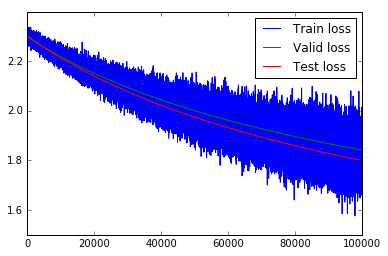

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

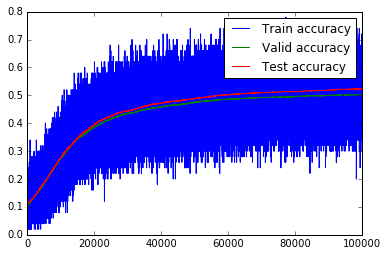

In [6]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()